# European Power Grid Forecasting
## Day-Ahead Price Forecasting

**Author:** ARIJIT SAMAL  
**Email:** arijit.samal@student-cs.fr  
**Date:** 30 December 2025  
**Market:** France (FR)

---

### Executive Summary

This notebook implements a complete pipeline for forecasting European day-ahead electricity prices using publicly available data from ENTSO-E. The analysis covers:

1. **Setup and configuration** - set the project with libs, dirs and configs
2. **Data Ingestion** - Automated fetching from ENTSO-E Transparency Platform (hourly)
3. **Data Quality** - Comprehensive QA checks with AI-assisted rule generation
4. **Exploratory Data Analysis** - Statistical analysis and visualization
5. **Forecasting** - Baseline and advanced ML models with walk-forward validation
6. **Prompt Curve Translation** - Converting forecasts to tradable views
7. **AI Integration** - LLM-powered automated analysis and reporting
8. **Submission File Generation** - generate the submission.csv file with timestamps and predictions

---

### Data Sources (ENTSO-E Transparency Platform)
**API Documentation:** https://pypi.org/project/entsoe-py/

## 1. Setup & Configuration

### 1.1 Environment Setup

In [1]:
import os
import sys
import json
import logging
import warnings
from datetime import datetime, timedelta
from pathlib import Path
from typing import Dict, List, Tuple, Optional


import numpy as np
import pandas as pd


import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from scipy import stats
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss

from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import lightgbm as lgb
import xgboost as xgb

from entsoe import EntsoePandasClient
from dotenv import load_dotenv

from tqdm.notebook import tqdm

import openai

warnings.filterwarnings('ignore')

if not os.path.exists('logs'):
    os.makedirs('logs')
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler('logs/pipeline.log'),
        logging.StreamHandler()
    ]
)
logger = logging.getLogger(__name__)

In [2]:
# Create necessary directories
DIRS = ['data', 'logs', 'outputs', 'models', 'reports']
for d in DIRS:
    Path(d).mkdir(parents=True, exist_ok=True)

### 1.2 Configuration Parameters

In [3]:
class Config:
    """Central configuration for the pipeline."""
    
    # Market Configuration
    COUNTRY_CODE = 'FR'  # France bidding zone
    COUNTRY_NAME = 'France'
    TIMEZONE = 'Europe/Paris'
    
    # Date Range (1 year of data)
    END_DATE = pd.Timestamp.now(tz=TIMEZONE).normalize()
    START_DATE = END_DATE - pd.DateOffset(years=1)
    
    # Train/Test Split
    TEST_DAYS = 30  # Last 30 days for out-of-sample testing
    VALIDATION_DAYS = 60  # 60 days for validation
    
    # Peak Hours Definition (french market convention)
    PEAK_HOURS = list(range(8, 20))  # 08:00-19:00 (French peak hours)
    OFFPEAK_HOURS = list(range(0, 8)) + list(range(20, 24))  # 00:00-07:00 and 20:00-23:00
    
    # Model Parameters
    FORECAST_HORIZON = 24  # Hours ahead to forecast
    CV_SPLITS = 5  # Number of walk-forward CV splits
    
    # File Paths
    DATA_DIR = Path('data')
    OUTPUT_DIR = Path('outputs')
    MODEL_DIR = Path('models')
    LOG_DIR = Path('logs')
    
    # Random seed for reproducibility
    RANDOM_STATE = 42

# Initialize config
config = Config()

print(f"Configuration Summary:")
print(f"   Market: {config.COUNTRY_NAME} ({config.COUNTRY_CODE})")
print(f"   Period: {config.START_DATE.strftime('%Y-%m-%d')} to {config.END_DATE.strftime('%Y-%m-%d')}")
print(f"   Timezone: {config.TIMEZONE}")
print(f"   Test period: Last {config.TEST_DAYS} days")

Configuration Summary:
   Market: France (FR)
   Period: 2024-12-30 to 2025-12-30
   Timezone: Europe/Paris
   Test period: Last 30 days


In [4]:
load_dotenv()

ENTSOE_API_KEY = os.getenv('ENTSOE_API_KEY')
OPENAI_API_KEY = os.getenv('OPENAI_API_KEY')

if not ENTSOE_API_KEY:
    raise ValueError("❌ ENTSOE_API_KEY not found in environment. Please set it in .env file.")
    
# Initialize ENTSO-E client
entsoe_client = EntsoePandasClient(api_key=ENTSOE_API_KEY)

# Initialize OpenAI client (if available)
if OPENAI_API_KEY:
    openai_client = openai.OpenAI(api_key=OPENAI_API_KEY)
    print("✅ OpenAI client initialized")
else:
    openai_client = None
    print("⚠️ OPENAI_API_KEY not found. AI features will be limited.")

print("✅ ENTSO-E client initialized")

✅ OpenAI client initialized
✅ ENTSO-E client initialized


---

## 2. Data Ingestion

**Source:** ENTSO-E Transparency Platform ([entsoe-py](https://pypi.org/project/entsoe-py/))

| Data              | Granularity | Role         |
|-------------------|-------------|--------------|
| Day-Ahead Prices  | Hourly      | **TARGET**   |
| Load Forecast     | Hourly      | **DRIVER 1** |
| Wind Forecast     | Hourly      | **DRIVER 2** |
| Solar Forecast    | Hourly      | **DRIVER 3** |

*Timezone: Europe/Paris (CET/CEST) - handled automatically by entsoe-py*

In [5]:
def fetch_entsoe_data(
    client: EntsoePandasClient,
    country_code: str,
    start: pd.Timestamp,
    end: pd.Timestamp
) -> pd.DataFrame:
    """
    Fetch data from ENTSO-E API with hourly granularity.
    
    Data Sources (ENTSO-E Transparency Platform):
    - Day-Ahead Prices: 12.1.D (A44) - TARGET
    - Load Forecast: 6.1.B (A65) - DRIVER 1
    - Wind/Solar Forecast: 14.1.D (A69) - DRIVERS 2 & 3
    """
    data_dict = {}
    
    # ==========================================================================
    # 1. DAY-AHEAD PRICES (TARGET)
    # ==========================================================================
    logger.info("📊 Fetching Day-Ahead Prices...")
    try:
        prices = client.query_day_ahead_prices(country_code, start=start, end=end)
        if isinstance(prices, pd.Series):
            data_dict['price_da'] = prices
        else:
            data_dict['price_da'] = prices.iloc[:, 0]
        logger.info(f"   ✓ Prices: {len(prices):,} records")
    except Exception as e:
        raise ValueError(f"Failed to fetch Day-Ahead Prices: {e}")
    
    # ==========================================================================
    # 2. LOAD FORECAST (DRIVER 1)
    # ==========================================================================
    logger.info("📊 Fetching Load Forecast...")
    try:
        load = client.query_load_forecast(country_code, start=start, end=end)
        if isinstance(load, pd.Series):
            data_dict['load_forecast'] = load
        else:
            data_dict['load_forecast'] = load.iloc[:, 0]
        logger.info(f"   ✓ Load: {len(load):,} records")
    except Exception as e:
        logger.warning(f"   ✗ Load Forecast failed: {e}")
    
    # ==========================================================================
    # 3. WIND & SOLAR FORECAST (DRIVERS 2 & 3)
    # ==========================================================================
    logger.info("📊 Fetching Wind/Solar Forecast...")
    try:
        renewables = client.query_wind_and_solar_forecast(country_code, start=start, end=end)
        
        # Log available columns for debugging
        logger.info(f"   Available columns: {list(renewables.columns)}")
        
        # Wind - check for various naming conventions (case-insensitive)
        wind_cols = [c for c in renewables.columns if 'wind' in str(c).lower()]
        if wind_cols:
            data_dict['wind_forecast'] = renewables[wind_cols].sum(axis=1)
            logger.info(f"   ✓ Wind: {len(renewables):,} records from {wind_cols}")
        
        # Solar - check for various naming conventions (case-insensitive)
        solar_cols = [c for c in renewables.columns if 'solar' in str(c).lower()]
        if solar_cols:
            data_dict['solar_forecast'] = renewables[solar_cols].sum(axis=1)
            logger.info(f"   ✓ Solar: {len(renewables):,} records from {solar_cols}")
        else:
            # Try alternative: sometimes solar is in a tuple column like ('Solar', 'Actual aggregated')
            for col in renewables.columns:
                col_str = str(col).lower()
                if 'solar' in col_str or 'pv' in col_str or 'photovoltaic' in col_str:
                    data_dict['solar_forecast'] = renewables[col]
                    logger.info(f"   ✓ Solar: {len(renewables):,} records from {col}")
                    break
            
            if 'solar_forecast' not in data_dict:
                logger.warning(f"   ✗ Solar column not found in: {list(renewables.columns)}")
                
    except Exception as e:
        logger.warning(f"   ✗ Wind/Solar failed: {e}")
    
    # ==========================================================================
    # COMBINE AND RESAMPLE TO HOURLY
    # ==========================================================================
    df = pd.DataFrame(data_dict)
    
    # Ensure timezone
    if df.index.tz is None:
        df.index = df.index.tz_localize(config.TIMEZONE, ambiguous='infer', nonexistent='shift_forward')
    else:
        df.index = df.index.tz_convert(config.TIMEZONE)
    
    # Resample to hourly
    df = df.resample('h').mean()
    
    # Summary
    logger.info("=" * 50)
    logger.info(f"📋 Data: {len(df):,} hours")
    logger.info(f"   Columns: {list(df.columns)}")
    for col in df.columns:
        non_zero = (df[col] != 0).sum()
        logger.info(f"   {col}: {non_zero:,} non-zero values, mean={df[col].mean():.2f}")
    
    return df


In [6]:
# Fetch data from ENTSO-E
df_raw = fetch_entsoe_data(
    client=entsoe_client,
    country_code=config.COUNTRY_CODE,
    start=config.START_DATE,
    end=config.END_DATE
)

# Save to cache
df_raw.to_csv(config.DATA_DIR / 'raw_entsoe_data.csv')

# Preview
print(f"✅ Data: {len(df_raw):,} hours, {df_raw.index.min().date()} to {df_raw.index.max().date()}")


2025-12-30 19:38:46,978 - INFO - 📊 Fetching Day-Ahead Prices...
2025-12-30 19:38:54,045 - INFO -    ✓ Prices: 15,243 records
2025-12-30 19:38:54,045 - INFO - 📊 Fetching Load Forecast...
2025-12-30 19:38:58,108 - INFO -    ✓ Load: 34,965 records
2025-12-30 19:38:58,109 - INFO - 📊 Fetching Wind/Solar Forecast...
2025-12-30 19:39:03,967 - INFO -    Available columns: ['Solar', 'Wind Offshore', 'Wind Onshore']
2025-12-30 19:39:03,969 - INFO -    ✓ Wind: 8,760 records from ['Wind Offshore', 'Wind Onshore']
2025-12-30 19:39:03,970 - INFO -    ✓ Solar: 8,760 records from ['Solar']
2025-12-30 19:39:03,976 - INFO - ==================================================
2025-12-30 19:39:03,977 - INFO - 📋 Data: 8,761 hours
2025-12-30 19:39:03,977 - INFO -    Columns: ['price_da', 'load_forecast', 'wind_forecast', 'solar_forecast']
2025-12-30 19:39:03,977 - INFO -    price_da: 8,542 non-zero values, mean=61.19
2025-12-30 19:39:03,978 - INFO -    load_forecast: 8,761 non-zero values, mean=49665.56
2025

✅ Data: 8,761 hours, 2024-12-30 to 2025-12-30


In [7]:
df_raw.sample(10)

,price_da,load_forecast,wind_forecast,solar_forecast
2025-11-02 03:00:00+01:00,16.2775,36999.375,7521.06885,0.00
2025-01-28 04:00:00+01:00,0.6500,51912.500,18479.30000,0.00
2025-03-15 11:00:00+01:00,65.1500,60800.000,10260.40000,9481.22
2025-01-08 08:00:00+01:00,135.0100,69750.000,4810.01000,0.00
2025-08-31 15:00:00+02:00,-0.0100,37925.000,3065.42000,8812.33
2025-09-15 23:00:00+02:00,4.2900,43425.000,13866.25000,0.00
2025-03-05 08:00:00+01:00,125.1800,66675.000,2859.08000,1342.52
2025-04-30 02:00:00+02:00,20.1400,36500.000,5074.10000,0.00
2025-10-13 16:00:00+02:00,45.8075,47137.500,6011.13000,11893.93
2025-01-04 17:00:00+01:00,136.7800,66087.500,6123.75000,49.92


In [8]:
df_raw.describe()

,price_da,load_forecast,wind_forecast,solar_forecast
count,8761.000000,8760.000000,8760.000000,8760.000000
mean,61.190939,49665.561758,5807.411963,3590.826762
std,46.485539,10707.376368,4027.452906,5100.062980
min,-118.010000,28414.625000,279.453740,0.000000
25%,20.950000,41774.218750,2780.540000,0.000000
50%,60.000000,47550.000000,4659.480000,135.065000
75%,93.520000,56900.000000,7909.262500,6501.260000
max,473.280000,84010.500000,22902.760000,19745.700000


### 2.1 Timezone & DST Verification

**France (FR)** operates on:
- **CET** (Central European Time, UTC+1) in winter
- **CEST** (Central European Summer Time, UTC+2) in summer

DST transitions cause:
- **Spring forward** (last Sunday of March): 23 hours in day (1 hour missing)
- **Fall back** (last Sunday of October): 25 hours in day (1 hour repeated)

Below we verify proper timezone handling and identify any DST transition days.

In [9]:
# Timezone & DST Verification
print("🕐 TIMEZONE & DST VERIFICATION")
print("=" * 50)

# Verify timezone
print(f"Timezone: {df_raw.index.tz}")
print(f"UTC offsets in data: {df_raw.index.map(lambda x: x.utcoffset()).unique()}")

# Check for DST transition days (23 or 25 hours)
daily_hours = df_raw.groupby(df_raw.index.date).size()
dst_days = daily_hours[daily_hours != 24]

if len(dst_days) > 0:
    print(f"\n📅 DST Transition Days Found:")
    for date, hours in dst_days.items():
        transition = "Spring forward (23h)" if hours == 23 else "Fall back (25h)" if hours == 25 else f"Irregular ({hours}h)"
        print(f"   {date}: {hours} hours - {transition}")
else:
    print("\n✓ No DST transitions in date range (or handled correctly)")

# Verify no duplicate timestamps
duplicates = df_raw.index.duplicated().sum()
print(f"\n✓ Duplicate timestamps: {duplicates}")
print(f"✓ Index is monotonic: {df_raw.index.is_monotonic_increasing}")
print(f"✓ Total hours: {len(df_raw):,}")

🕐 TIMEZONE & DST VERIFICATION
Timezone: Europe/Paris
UTC offsets in data: TimedeltaIndex(['0 days 01:00:00', '0 days 02:00:00'], dtype='timedelta64[ns]', freq=None)

📅 DST Transition Days Found:
   2025-03-30: 23 hours - Spring forward (23h)
   2025-10-26: 25 hours - Fall back (25h)
   2025-12-30: 1 hours - Irregular (1h)

✓ Duplicate timestamps: 0
✓ Index is monotonic: True
✓ Total hours: 8,761


---

## 3. Data Quality & Cleaning

### 3.1 Data Quality Assessment Framework

A comprehensive QA framework checks for:
1. **Missing Values** - Gaps in the time series
2. **Duplicate Records** - Redundant timestamps
3. **Outliers** - Extreme values (statistical and domain-based)
4. **Coverage** - Data completeness per field and time period
5. **Consistency** - Cross-field validation (e.g., renewable generation <= load)

In [10]:
class DataQualityReport:    
    def __init__(self, df: pd.DataFrame, name: str = "Dataset"):
        self.df = df
        self.name = name
        self.report = {}
        
    def run_all_checks(self) -> Dict:
        self.check_missing_values()
        self.check_duplicates()
        self.check_outliers()
        self.check_coverage()
        self.check_data_types()
        self.check_value_ranges()
        return self.report
    
    def check_missing_values(self):
        missing = self.df.isnull().sum()
        missing_pct = (missing / len(self.df)) * 100
        
        self.report['missing_values'] = {
            'counts': missing.to_dict(),
            'percentages': missing_pct.to_dict(),
            'total_rows': len(self.df),
            'complete_rows': len(self.df.dropna()),
            'complete_pct': (len(self.df.dropna()) / len(self.df)) * 100
        }
        
    def check_duplicates(self):
        """Check for duplicate timestamps."""
        duplicates = self.df.index.duplicated()
        dup_count = duplicates.sum()
        
        self.report['duplicates'] = {
            'count': int(dup_count),
            'percentage': (dup_count / len(self.df)) * 100,
            'duplicate_indices': list(self.df.index[duplicates][:10])  # First 10
        }
        
    def check_outliers(self):
        """Check for statistical outliers using IQR and Z-score."""
        outliers = {}
        
        for col in self.df.select_dtypes(include=[np.number]).columns:
            series = self.df[col].dropna()
            
            # IQR method
            Q1 = series.quantile(0.25)
            Q3 = series.quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            iqr_outliers = ((series < lower_bound) | (series > upper_bound)).sum()
            
            # Z-score method
            z_scores = np.abs(stats.zscore(series))
            zscore_outliers = (z_scores > 3).sum()
            
            outliers[col] = {
                'iqr_outliers': int(iqr_outliers),
                'zscore_outliers': int(zscore_outliers),
                'lower_bound': lower_bound,
                'upper_bound': upper_bound,
                'min': series.min(),
                'max': series.max()
            }
            
        self.report['outliers'] = outliers
        
    def check_coverage(self):
        """Check data coverage by time period."""
        coverage = {}
        
        # Hourly coverage
        expected_hours = pd.date_range(
            start=self.df.index.min(),
            end=self.df.index.max(),
            freq='h'
        )
        actual_hours = self.df.index
        
        coverage['expected_hours'] = len(expected_hours)
        coverage['actual_hours'] = len(actual_hours)
        coverage['hourly_coverage_pct'] = (len(actual_hours) / len(expected_hours)) * 100
        
        # Monthly coverage
        monthly = self.df.groupby(self.df.index.to_period('M')).size()
        coverage['monthly_counts'] = monthly.to_dict()
        
        self.report['coverage'] = coverage
        
    def check_data_types(self):
        """Check data types."""
        self.report['data_types'] = self.df.dtypes.astype(str).to_dict()
        
    def check_value_ranges(self):
        """Check if values are within expected ranges."""
        ranges = {}
        
        # Domain-specific checks for power data
        expected_ranges = {
            'price_da': (-500, 1000),  # EUR/MWh - can be negative!
            'load_forecast': (25000, 100000),  # MW for France
            'wind_forecast': (0, 25000),  # MW
            'solar_forecast': (0, 20000),  # MW
        }
        
        for col, (min_val, max_val) in expected_ranges.items():
            if col in self.df.columns:
                series = self.df[col].dropna()
                below_min = (series < min_val).sum()
                above_max = (series > max_val).sum()
                
                ranges[col] = {
                    'expected_range': (min_val, max_val),
                    'actual_range': (series.min(), series.max()),
                    'below_minimum': int(below_min),
                    'above_maximum': int(above_max)
                }
                
        self.report['value_ranges'] = ranges
        
    def print_summary(self):
        """Print formatted summary of QA report."""
        print("")
        print("=" * 60)
        print(f"DATA QUALITY REPORT: {self.name}")
        print("=" * 60)
        print("")
        
        # Missing values
        print("1. MISSING VALUES")
        print("-" * 40)
        mv = self.report.get('missing_values', {})
        for col, count in mv.get('counts', {}).items():
            pct = mv.get('percentages', {}).get(col, 0)
            if pct < 1:
                status = "OK"
            elif pct < 5:
                status = "WARNING"
            else:
                status = "ERROR"
            print(f"   [{status}] {col}: {count} ({pct:.2f}%)")
        print(f"   Complete rows: {mv.get('complete_pct', 0):.1f}%")
        print("")
        
        # Duplicates
        print("2. DUPLICATES")
        print("-" * 40)
        dup = self.report.get('duplicates', {})
        dup_count = dup.get('count', 0)
        status = "OK" if dup_count == 0 else "ERROR"
        print(f"   [{status}] Duplicate timestamps: {dup_count}")
        print("")
        
        # Outliers
        print("3. OUTLIERS (IQR method)")
        print("-" * 40)
        for col, stats in self.report.get('outliers', {}).items():
            count = stats.get('iqr_outliers', 0)
            if count < 100:
                status = "OK"
            elif count < 500:
                status = "WARNING"
            else:
                status = "ERROR"
            print(f"   [{status}] {col}: {count} outliers")
        print("")
        
        # Coverage
        print("4. DATA COVERAGE")
        print("-" * 40)
        cov = self.report.get('coverage', {})
        coverage_pct = cov.get('hourly_coverage_pct', 0)
        if coverage_pct > 99:
            status = "OK"
        elif coverage_pct > 95:
            status = "WARNING"
        else:
            status = "ERROR"
        print(f"   [{status}] Hourly coverage: {coverage_pct:.2f}%")
        print(f"   Expected: {cov.get('expected_hours', 0)} hours")
        print(f"   Actual: {cov.get('actual_hours', 0)} hours")
        print("")
        
        # Value ranges
        print("5. VALUE RANGES")
        print("-" * 40)
        for col, stats in self.report.get('value_ranges', {}).items():
            issues = stats.get('below_minimum', 0) + stats.get('above_maximum', 0)
            status = "OK" if issues == 0 else "WARNING"
            actual = stats.get('actual_range', (0, 0))
            expected = stats.get('expected_range', (0, 0))
            print(f"   [{status}] {col}:")
            print(f"      Expected: {expected}")
            print(f"      Actual: ({actual[0]:.1f}, {actual[1]:.1f})")
        
        print("")
        print("=" * 60)

In [11]:
# Run QA checks
qa = DataQualityReport(df_raw, name="ENTSO-E Raw Data")
qa_results = qa.run_all_checks()
qa.print_summary()

# Save QA report - with proper JSON serialization
def make_json_serializable(obj):
    """Convert non-serializable objects to JSON-compatible types."""
    if isinstance(obj, dict):
        # Convert keys to strings (JSON requires string keys) and values recursively
        return {str(k): make_json_serializable(v) for k, v in obj.items()}
    elif isinstance(obj, (list, tuple)):
        return [make_json_serializable(item) for item in obj]
    elif isinstance(obj, (np.integer, np.floating)):
        return float(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, (pd.Timestamp, pd.Period)):
        return str(obj)
    elif hasattr(obj, 'isoformat'):
        return obj.isoformat()
    else:
        return obj

qa_report_path = config.OUTPUT_DIR / 'data_quality_report.json'
with open(qa_report_path, 'w') as f:
    serializable_results = make_json_serializable(qa_results)
    json.dump(serializable_results, f, indent=2, default=str)
    
print(f"📁 QA report saved to: {qa_report_path}")



DATA QUALITY REPORT: ENTSO-E Raw Data

1. MISSING VALUES
----------------------------------------
   [OK] price_da: 0 (0.00%)
   [OK] load_forecast: 1 (0.01%)
   [OK] wind_forecast: 1 (0.01%)
   [OK] solar_forecast: 1 (0.01%)
   Complete rows: 100.0%

2. DUPLICATES
----------------------------------------
   [OK] Duplicate timestamps: 0

3. OUTLIERS (IQR method)
----------------------------------------
   [OK] price_da: 35 outliers
   [OK] load_forecast: 46 outliers
   [WARNING] wind_forecast: 283 outliers
   [WARNING] solar_forecast: 262 outliers

4. DATA COVERAGE
----------------------------------------
   [OK] Hourly coverage: 100.00%
   Expected: 8761 hours
   Actual: 8761 hours

5. VALUE RANGES
----------------------------------------
   [OK] price_da:
      Expected: (-500, 1000)
      Actual: (-118.0, 473.3)
   [OK] load_forecast:
      Expected: (25000, 100000)
      Actual: (28414.6, 84010.5)
   [OK] wind_forecast:
      Expected: (0, 25000)
      Actual: (279.5, 22902.8)
   

### 3.2 Data Cleaning

Based on the QA report:
- ❌ **No duplicates** (0 found)
- ❌ **No invalid outliers** (all values within expected ranges)
- ✅ **Drop 1 incomplete row** (last hour missing forecast data)

In [12]:
def clean_data(df: pd.DataFrame) -> pd.DataFrame:
    """
    Clean the raw data based on QA report findings.
    
    QA Report Summary:
    - Missing: Only 1 row (last hour) has NaN in load/wind/solar
    - Duplicates: 0
    - Outliers: All values within expected ranges (no action needed)
    - Coverage: 100% hourly
    """
    logger.info("Cleaning data based on QA report...")
    df_clean = df.copy()
    
    # Drop the 1 incomplete row (last hour has NaN for forecasts)
    rows_before = len(df_clean)
    df_clean = df_clean.dropna()
    dropped = rows_before - len(df_clean)
    logger.info(f"  Dropped {dropped} row(s) with missing values")
    
    # Verify hourly frequency
    expected_hours = len(pd.date_range(df_clean.index.min(), df_clean.index.max(), freq='h'))
    actual_hours = len(df_clean)
    logger.info(f"  Hourly coverage: {actual_hours}/{expected_hours} ({100*actual_hours/expected_hours:.1f}%)")
    
    logger.info(f"✓ Cleaning complete: {df_clean.shape}")
    return df_clean

# Apply cleaning
df_clean = clean_data(df_raw)

print(f"\n✅ Clean dataset: {df_clean.shape[0]:,} hours × {df_clean.shape[1]} columns")
print(f"   Range: {df_clean.index.min().date()} to {df_clean.index.max().date()}")

2025-12-30 19:39:04,072 - INFO - Cleaning data based on QA report...
2025-12-30 19:39:04,073 - INFO -   Dropped 1 row(s) with missing values
2025-12-30 19:39:04,073 - INFO -   Hourly coverage: 8760/8760 (100.0%)
2025-12-30 19:39:04,074 - INFO - ✓ Cleaning complete: (8760, 4)



✅ Clean dataset: 8,760 hours × 4 columns
   Range: 2024-12-30 to 2025-12-29


In [13]:
df_clean.to_csv(os.path.join(config.DATA_DIR, "cleaned_data.csv"))

---

## 4. Exploratory Data Analysis (EDA)

### 4.1 Time Series Visualization

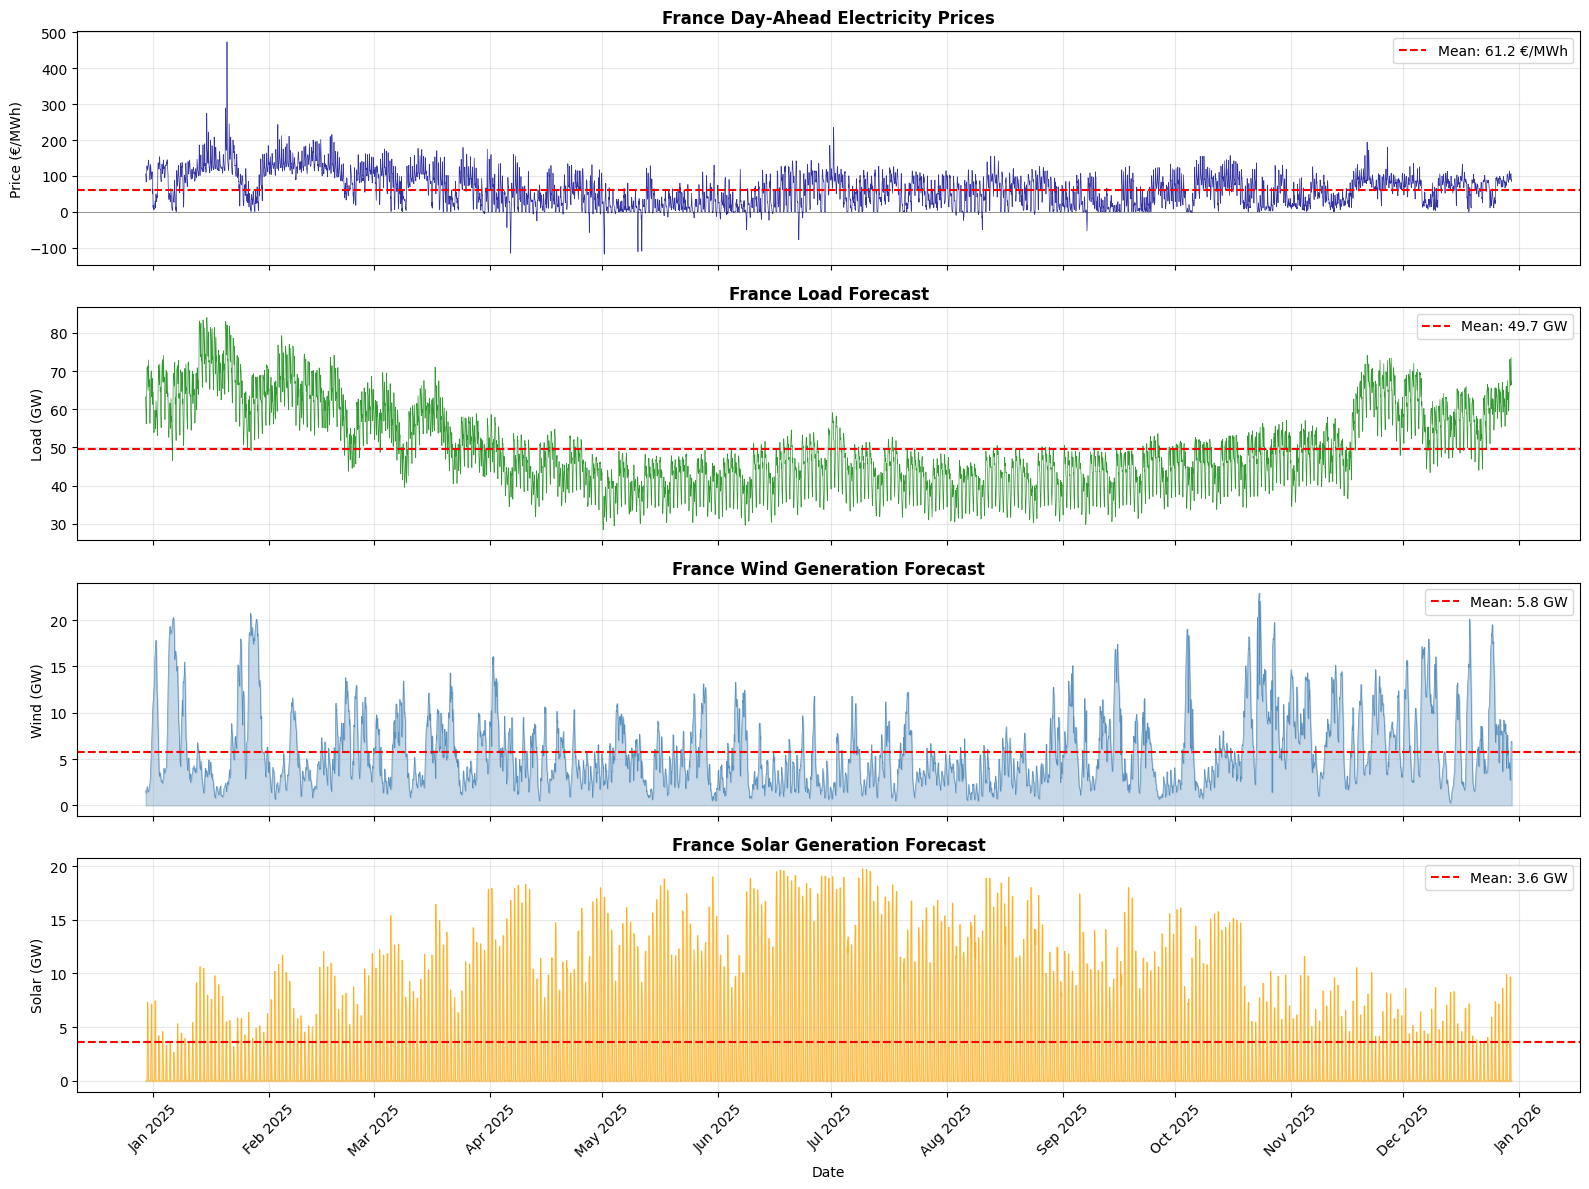

In [14]:
# Time Series Visualization
fig, axes = plt.subplots(4, 1, figsize=(16, 12), sharex=True)

# 1. Day-Ahead Prices
ax1 = axes[0]
ax1.plot(df_clean.index, df_clean['price_da'], color='darkblue', linewidth=0.5, alpha=0.8)
ax1.axhline(y=df_clean['price_da'].mean(), color='red', linestyle='--', linewidth=1.5, 
            label=f'Mean: {df_clean["price_da"].mean():.1f} €/MWh')
ax1.axhline(y=0, color='black', linestyle='-', linewidth=0.5, alpha=0.5)
ax1.set_ylabel('Price (€/MWh)')
ax1.set_title('France Day-Ahead Electricity Prices', fontweight='bold')
ax1.legend(loc='upper right')
ax1.grid(True, alpha=0.3)

# 2. Load Forecast
ax2 = axes[1]
ax2.plot(df_clean.index, df_clean['load_forecast']/1000, color='green', linewidth=0.5, alpha=0.8)
ax2.axhline(y=df_clean['load_forecast'].mean()/1000, color='red', linestyle='--', linewidth=1.5,
            label=f'Mean: {df_clean["load_forecast"].mean()/1000:.1f} GW')
ax2.set_ylabel('Load (GW)')
ax2.set_title('France Load Forecast', fontweight='bold')
ax2.legend(loc='upper right')
ax2.grid(True, alpha=0.3)

# 3. Wind Forecast
ax3 = axes[2]
ax3.plot(df_clean.index, df_clean['wind_forecast']/1000, color='steelblue', linewidth=0.5, alpha=0.8)
ax3.fill_between(df_clean.index, 0, df_clean['wind_forecast']/1000, alpha=0.3, color='steelblue')
ax3.axhline(y=df_clean['wind_forecast'].mean()/1000, color='red', linestyle='--', linewidth=1.5,
            label=f'Mean: {df_clean["wind_forecast"].mean()/1000:.1f} GW')
ax3.set_ylabel('Wind (GW)')
ax3.set_title('France Wind Generation Forecast', fontweight='bold')
ax3.legend(loc='upper right')
ax3.grid(True, alpha=0.3)

# 4. Solar Forecast
ax4 = axes[3]
ax4.plot(df_clean.index, df_clean['solar_forecast']/1000, color='orange', linewidth=0.5, alpha=0.8)
ax4.fill_between(df_clean.index, 0, df_clean['solar_forecast']/1000, alpha=0.3, color='orange')
ax4.axhline(y=df_clean['solar_forecast'].mean()/1000, color='red', linestyle='--', linewidth=1.5,
            label=f'Mean: {df_clean["solar_forecast"].mean()/1000:.1f} GW')
ax4.set_ylabel('Solar (GW)')
ax4.set_title('France Solar Generation Forecast', fontweight='bold')
ax4.legend(loc='upper right')
ax4.grid(True, alpha=0.3)

ax4.set_xlabel('Date')
ax4.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax4.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.xticks(rotation=45)

plt.tight_layout()
plt.savefig(config.OUTPUT_DIR / 'eda_timeseries.png', dpi=150, bbox_inches='tight')
plt.show()

**Key Observations:**
- **Price volatility** is high with occasional spikes >200 €/MWh and negative prices
- **Load** shows clear seasonality (winter peaks ~80 GW, summer troughs ~30 GW) and weekly patterns
- **Wind** is highly variable (0-23 GW) with no clear seasonal pattern weather driven
- **Solar** has strong seasonality (summer ~20 GW peak, winter ~5 GW)

### 4.2 Price Distribution Analysis

Understanding price patterns across different time dimensions is crucial for building accurate forecasting models:
- **Histogram**: Overall distribution shape and outliers
- **Monthly/Hourly/Weekly**: Seasonal and cyclical patterns
- **Scatter plots**: Relationship between price and fundamental drivers

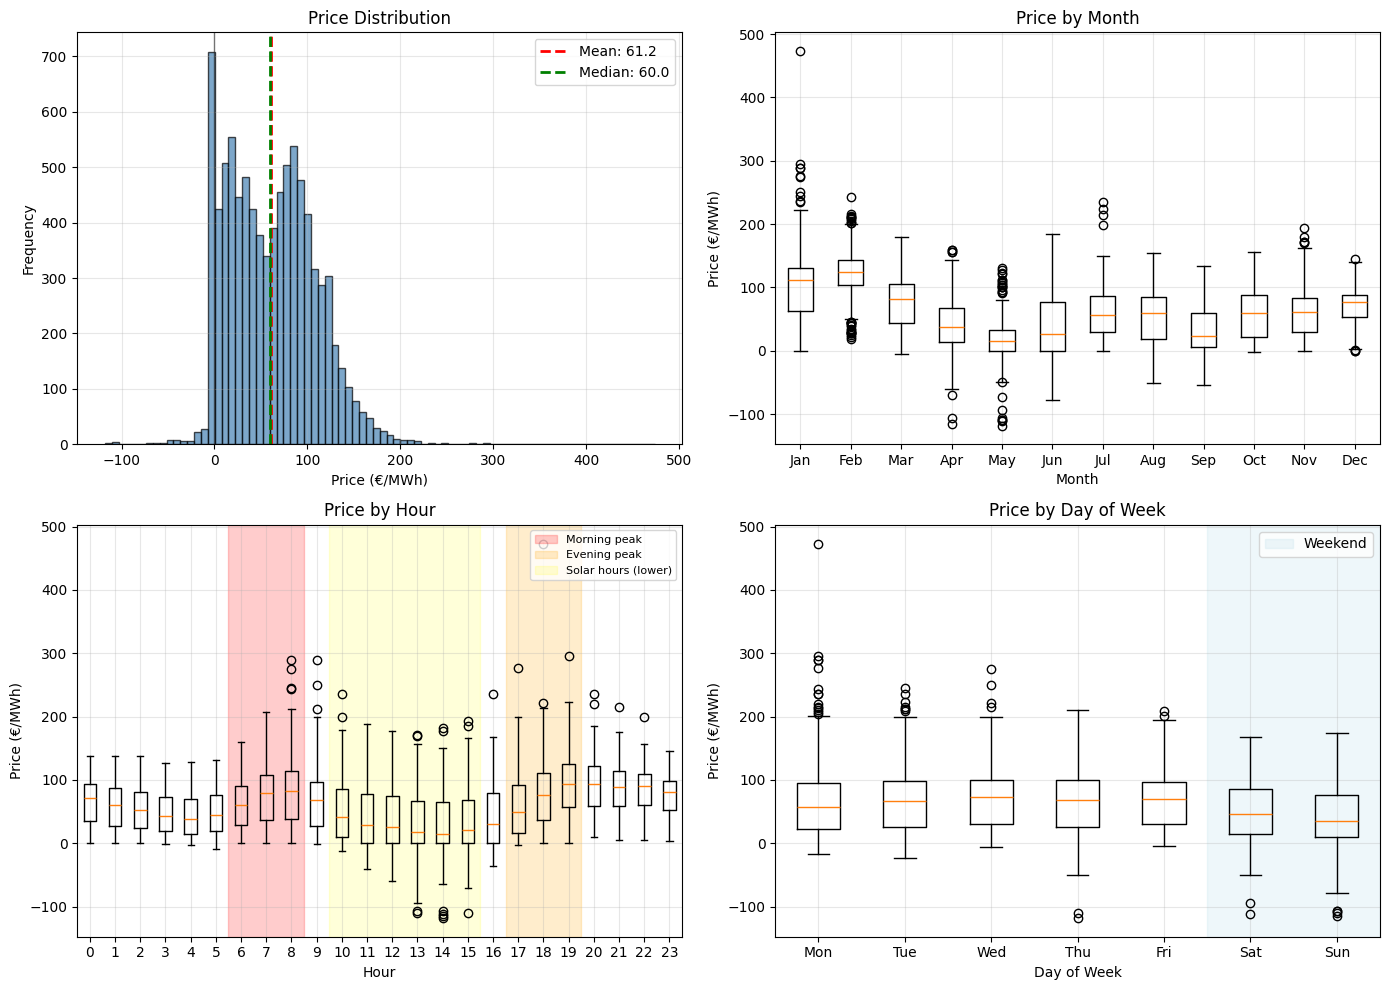

In [15]:
# Price Distribution Analysis
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Price Histogram
ax1 = axes[0, 0]
ax1.hist(df_clean['price_da'], bins=80, edgecolor='black', alpha=0.7, color='steelblue')
ax1.axvline(df_clean['price_da'].mean(), color='red', linestyle='--', lw=2, label=f'Mean: {df_clean["price_da"].mean():.1f}')
ax1.axvline(df_clean['price_da'].median(), color='green', linestyle='--', lw=2, label=f'Median: {df_clean["price_da"].median():.1f}')
ax1.axvline(0, color='black', linestyle='-', lw=1, alpha=0.5)
ax1.set_xlabel('Price (€/MWh)')
ax1.set_ylabel('Frequency')
ax1.set_title('Price Distribution')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Monthly boxplot
ax2 = axes[0, 1]
df_clean['month'] = df_clean.index.month
monthly_data = [df_clean[df_clean['month'] == m]['price_da'].dropna().values for m in range(1, 13)]
month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
valid_months = [(d, l) for d, l in zip(monthly_data, month_labels) if len(d) > 0]
ax2.boxplot([d for d, l in valid_months], labels=[l for d, l in valid_months])
ax2.set_xlabel('Month')
ax2.set_ylabel('Price (€/MWh)')
ax2.set_title('Price by Month')
ax2.grid(True, alpha=0.3)

# 3. Hourly boxplot - with correct interpretation
ax3 = axes[1, 0]
df_clean['hour'] = df_clean.index.hour
hourly_data = [df_clean[df_clean['hour'] == h]['price_da'].values for h in range(24)]
hourly_means = [df_clean[df_clean['hour'] == h]['price_da'].mean() for h in range(24)]
bp = ax3.boxplot(hourly_data, labels=range(24))
# Highlight actual high-price hours (morning & evening peaks)
ax3.axvspan(6.5, 9.5, alpha=0.2, color='red', label='Morning peak')
ax3.axvspan(17.5, 20.5, alpha=0.2, color='orange', label='Evening peak')
ax3.axvspan(10.5, 16.5, alpha=0.15, color='yellow', label='Solar hours (lower)')
ax3.set_xlabel('Hour')
ax3.set_ylabel('Price (€/MWh)')
ax3.set_title('Price by Hour')
ax3.legend(loc='upper right', fontsize=8)
ax3.grid(True, alpha=0.3)

# 4. Day of week boxplot
ax4 = axes[1, 1]
df_clean['dayofweek'] = df_clean.index.dayofweek
dow_data = [df_clean[df_clean['dayofweek'] == d]['price_da'].values for d in range(7)]
ax4.boxplot(dow_data, labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
ax4.axvspan(5.5, 7.5, alpha=0.2, color='lightblue', label='Weekend')
ax4.set_xlabel('Day of Week')
ax4.set_ylabel('Price (€/MWh)')
ax4.set_title('Price by Day of Week')
ax4.legend(loc='upper right')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(config.OUTPUT_DIR / 'eda_distributions.png', dpi=150, bbox_inches='tight')
plt.show()

# # Print hourly pattern summary
# print("\n📊 Hourly Price Pattern:")
# for h in range(24):
#     mean_price = df_clean[df_clean['hour'] == h]['price_da'].mean()
#     marker = "🔴" if h in [7,8,9,18,19,20] else "🟡" if h in [11,12,13,14,15] else "⚪"
#     print(f"   {marker} Hour {h:02d}: {mean_price:.1f} €/MWh")

**Key Observations:**

1. **Distribution**: Right-skewed with mean (61 €/MWh) > median (~60 €/MWh). Occasional negative prices and spikes up to 473 €/MWh.

2. **Monthly Pattern**: 
   - Winter (Jan-Feb): Higher prices due to heating demand & low solar
   - Summer: Lower average but more variability

3. **Hourly Pattern** (key insight!):
   - **Morning peak (7-9h)**: Highest prices - demand rises before solar kicks in
   - **Midday (11-16h)**: LOWER prices due to solar generation ("solar valley")
   - **Evening peak (18-20h)**: High prices - demand stays high after solar drops
   - **Night (0-6h)**: Lowest prices - minimal demand

4. **Weekly Pattern**: Weekdays ~10-15% higher than weekends (industrial demand)

### 4.2.1 Driver Distribution Analysis

Analyzing the patterns in our fundamental drivers helps understand their predictive potential:

2025-12-30 19:39:05,599 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-12-30 19:39:05,599 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-12-30 19:39:05,622 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-12-30 19:39:05,623 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-12-30 19:39:05,645 - INFO - Using categorical units to plot a list of strings that are all parsable as 

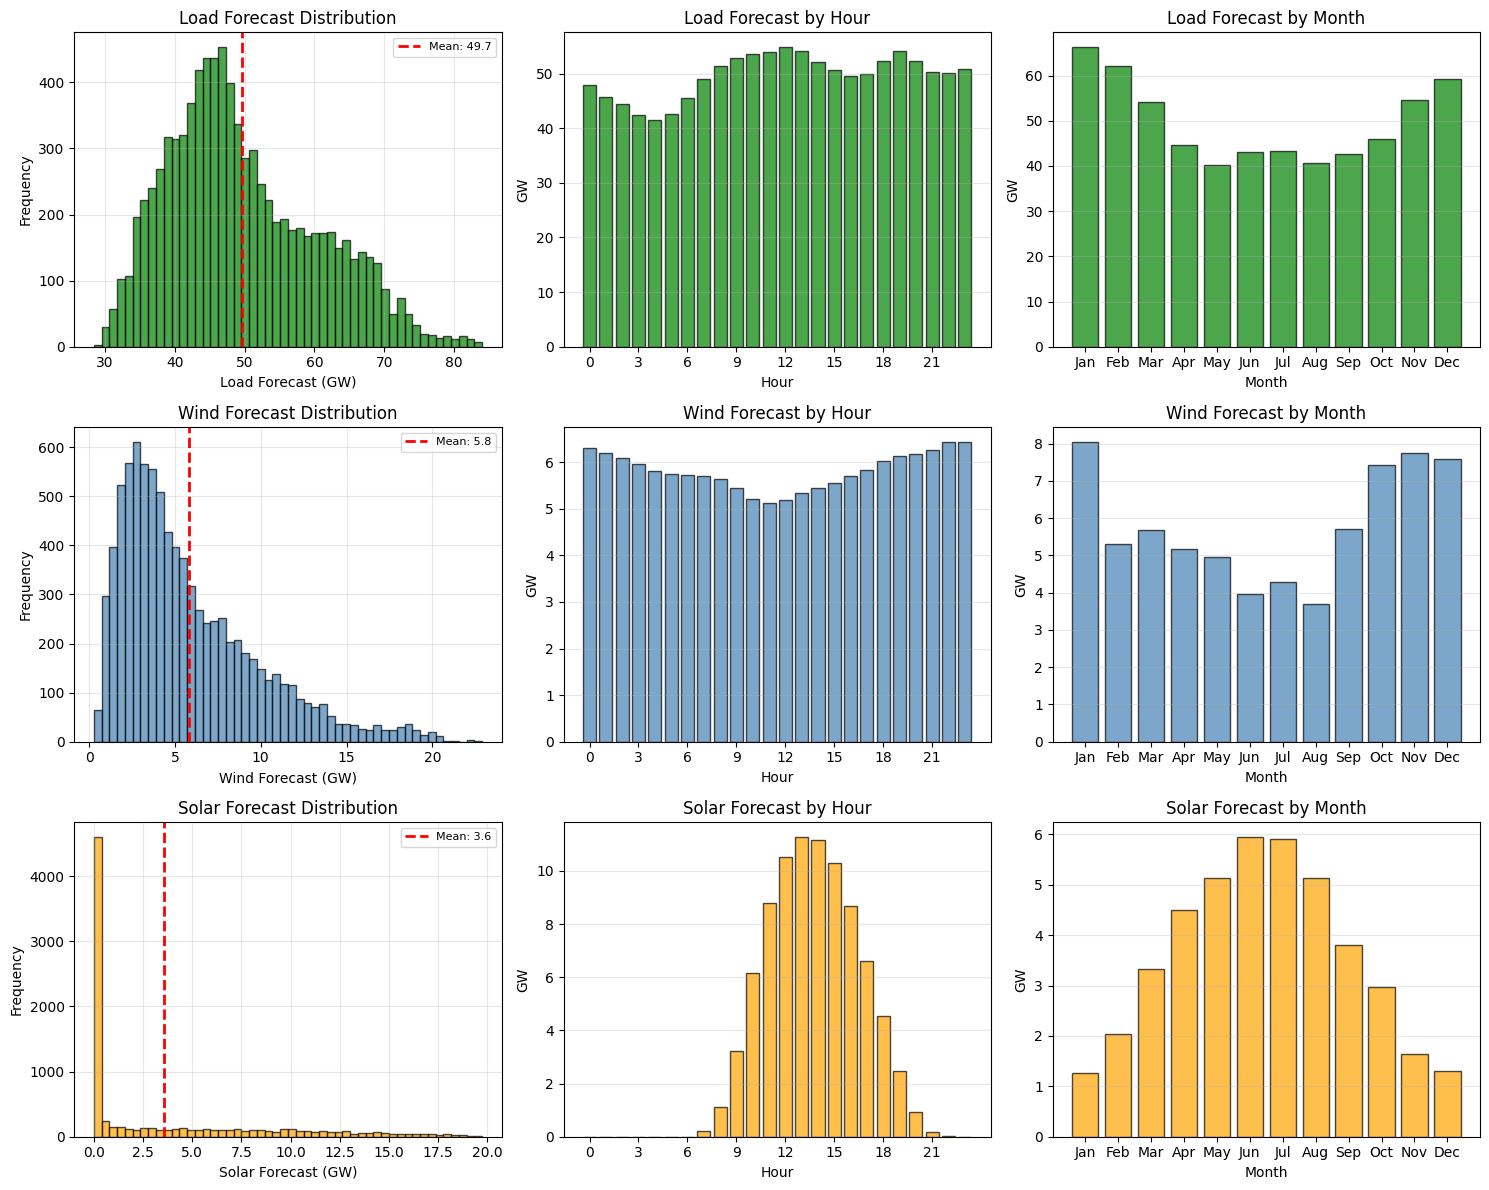

In [16]:
# Driver Distribution Analysis
fig, axes = plt.subplots(3, 3, figsize=(15, 12))

drivers = [
    ('load_forecast', 'Load Forecast', 'green', 'GW'),
    ('wind_forecast', 'Wind Forecast', 'steelblue', 'GW'),
    ('solar_forecast', 'Solar Forecast', 'orange', 'GW')
]

for row, (col, name, color, unit) in enumerate(drivers):
    data = df_clean[col] / 1000  # Convert to GW
    
    # 1. Histogram
    ax1 = axes[row, 0]
    ax1.hist(data, bins=50, edgecolor='black', alpha=0.7, color=color)
    ax1.axvline(data.mean(), color='red', linestyle='--', lw=2, label=f'Mean: {data.mean():.1f}')
    ax1.set_xlabel(f'{name} ({unit})')
    ax1.set_ylabel('Frequency')
    ax1.set_title(f'{name} Distribution')
    ax1.legend(fontsize=8)
    ax1.grid(True, alpha=0.3)
    
    # 2. Hourly pattern
    ax2 = axes[row, 1]
    hourly_means = [df_clean[df_clean['hour'] == h][col].mean()/1000 for h in range(24)]
    ax2.bar(range(24), hourly_means, color=color, alpha=0.7, edgecolor='black')
    ax2.set_xlabel('Hour')
    ax2.set_ylabel(f'{unit}')
    ax2.set_title(f'{name} by Hour')
    ax2.set_xticks(range(0, 24, 3))
    ax2.grid(True, alpha=0.3, axis='y')
    
    # 3. Monthly pattern
    ax3 = axes[row, 2]
    monthly_means = [df_clean[df_clean['month'] == m][col].mean()/1000 for m in range(1, 13)]
    month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    valid_data = [(m, l) for m, l in zip(monthly_means, month_labels) if not np.isnan(m)]
    ax3.bar([l for m, l in valid_data], [m for m, l in valid_data], color=color, alpha=0.7, edgecolor='black')
    ax3.set_xlabel('Month')
    ax3.set_ylabel(f'{unit}')
    ax3.set_title(f'{name} by Month')
    ax3.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(config.OUTPUT_DIR / 'eda_driver_distributions.png', dpi=150, bbox_inches='tight')
plt.show()

# # Print summary statistics
# print("\n📊 Driver Statistics:")
# for col, name, _, _ in drivers:
#     data = df_clean[col] / 1000
#     print(f"\n   {name}:")
#     print(f"      Mean: {data.mean():.1f} GW | Std: {data.std():.1f} GW")
#     print(f"      Min: {data.min():.1f} GW | Max: {data.max():.1f} GW")

**Key Takeaways from Driver Analysis:**

**Load Forecast:**
- **Hourly**: Classic double-peak pattern - morning (8-9h) and evening (19-20h) peaks, overnight trough
- **Monthly**: Higher in winter (heating) and summer (cooling), lower in spring/autumn
- **Implication**: Strong predictor for price peaks

**Wind Forecast:**
- **Hourly**: Relatively flat - wind is weather-driven, not time-driven
- **Monthly**: Higher in winter months (stormier), lower in summer
- **Implication**: Good for capturing weather-driven price drops

**Solar Forecast:**
- **Hourly**: Perfect bell curve peaking at noon (12-14h), zero at night
- **Monthly**: Strong seasonality - summer peak (~15 GW), winter trough (~3 GW)
- **Implication**: Explains midday "solar valley" in prices

**Feature Engineering Ideas:**
- `residual_demand = load - wind - solar` (key price driver)
- `renewable_share = (wind + solar) / load` (merit order proxy)
- Hour and month as categorical/cyclical features

### 4.3 Price vs Fundamental Drivers

Understanding the relationship between price and its drivers is crucial for feature engineering:

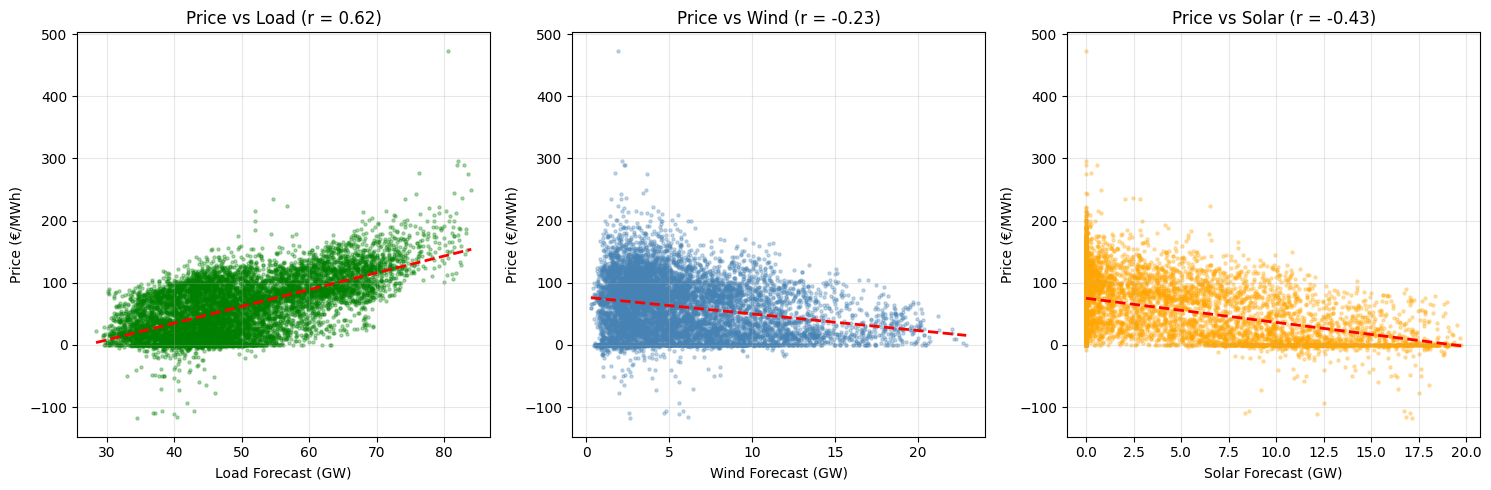


📊 Correlations with Price:
   Load:  +0.622 (positive - more demand → higher price)
   Wind:  -0.232 (negative - more wind → lower price)
   Solar: -0.425 (negative - more solar → lower price)


In [17]:
# Price vs Fundamental Drivers
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# 1. Price vs Load
ax1 = axes[0]
ax1.scatter(df_clean['load_forecast']/1000, df_clean['price_da'], alpha=0.3, s=5, c='green')
z = np.polyfit(df_clean['load_forecast']/1000, df_clean['price_da'], 1)
p = np.poly1d(z)
x_line = np.linspace(df_clean['load_forecast'].min()/1000, df_clean['load_forecast'].max()/1000, 100)
ax1.plot(x_line, p(x_line), 'r--', lw=2, label=f'Trend')
corr = df_clean['load_forecast'].corr(df_clean['price_da'])
ax1.set_xlabel('Load Forecast (GW)')
ax1.set_ylabel('Price (€/MWh)')
ax1.set_title(f'Price vs Load (r = {corr:.2f})')
ax1.grid(True, alpha=0.3)

# 2. Price vs Wind
ax2 = axes[1]
ax2.scatter(df_clean['wind_forecast']/1000, df_clean['price_da'], alpha=0.3, s=5, c='steelblue')
z = np.polyfit(df_clean['wind_forecast']/1000, df_clean['price_da'], 1)
p = np.poly1d(z)
x_line = np.linspace(df_clean['wind_forecast'].min()/1000, df_clean['wind_forecast'].max()/1000, 100)
ax2.plot(x_line, p(x_line), 'r--', lw=2)
corr = df_clean['wind_forecast'].corr(df_clean['price_da'])
ax2.set_xlabel('Wind Forecast (GW)')
ax2.set_ylabel('Price (€/MWh)')
ax2.set_title(f'Price vs Wind (r = {corr:.2f})')
ax2.grid(True, alpha=0.3)

# 3. Price vs Solar
ax3 = axes[2]
ax3.scatter(df_clean['solar_forecast']/1000, df_clean['price_da'], alpha=0.3, s=5, c='orange')
z = np.polyfit(df_clean['solar_forecast']/1000, df_clean['price_da'], 1)
p = np.poly1d(z)
x_line = np.linspace(df_clean['solar_forecast'].min()/1000, df_clean['solar_forecast'].max()/1000, 100)
ax3.plot(x_line, p(x_line), 'r--', lw=2)
corr = df_clean['solar_forecast'].corr(df_clean['price_da'])
ax3.set_xlabel('Solar Forecast (GW)')
ax3.set_ylabel('Price (€/MWh)')
ax3.set_title(f'Price vs Solar (r = {corr:.2f})')
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(config.OUTPUT_DIR / 'eda_scatter.png', dpi=150, bbox_inches='tight')
plt.show()

# Print correlations
print("\n📊 Correlations with Price:")
print(f"   Load:  {df_clean['load_forecast'].corr(df_clean['price_da']):+.3f} (positive - more demand → higher price)")
print(f"   Wind:  {df_clean['wind_forecast'].corr(df_clean['price_da']):+.3f} (negative - more wind → lower price)")
print(f"   Solar: {df_clean['solar_forecast'].corr(df_clean['price_da']):+.3f} (negative - more solar → lower price)")

**Driver Relationships:**

- **Load → Price**: Positive correlation. Higher demand pushes prices up (supply/demand economics)

- **Wind → Price**: Negative correlation. Wind has near-zero marginal cost, so high wind pushes expensive generators out of the merit order

- **Solar → Price**: Negative correlation. Same merit order effect. Solar causes the "midday price valley" observed in hourly patterns

These relationships confirm the **merit order effect**: renewables with zero fuel cost displace expensive fossil generators, lowering wholesale prices.

### 4.4 Correlation Matrix

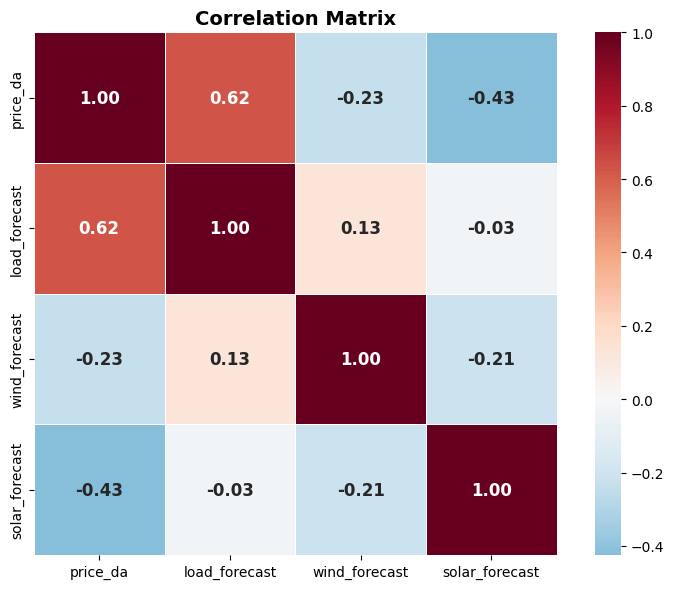

In [18]:
# Correlation Matrix
numeric_cols = ['price_da', 'load_forecast', 'wind_forecast', 'solar_forecast']
corr_matrix = df_clean[numeric_cols].corr()

fig, ax = plt.subplots(figsize=(8, 6))
# mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='RdBu_r', 
            center=0, ax=ax, square=True, linewidths=0.5,
            annot_kws={'size': 12, 'weight': 'bold'})
ax.set_title('Correlation Matrix', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig(config.OUTPUT_DIR / 'eda_correlations.png', dpi=150, bbox_inches='tight')
plt.show()

### 4.5 Seasonality & Stationarity Analysis

**Seasonal Decomposition** breaks down the price signal into interpretable components:

```
Price = Trend + Seasonal + Residual
```

- **Trend**: Slow-moving baseline (days/weeks)
- **Seasonal**: Repeating daily pattern (24-hour cycle)
- **Residual**: Everything else (noise, events, errors)

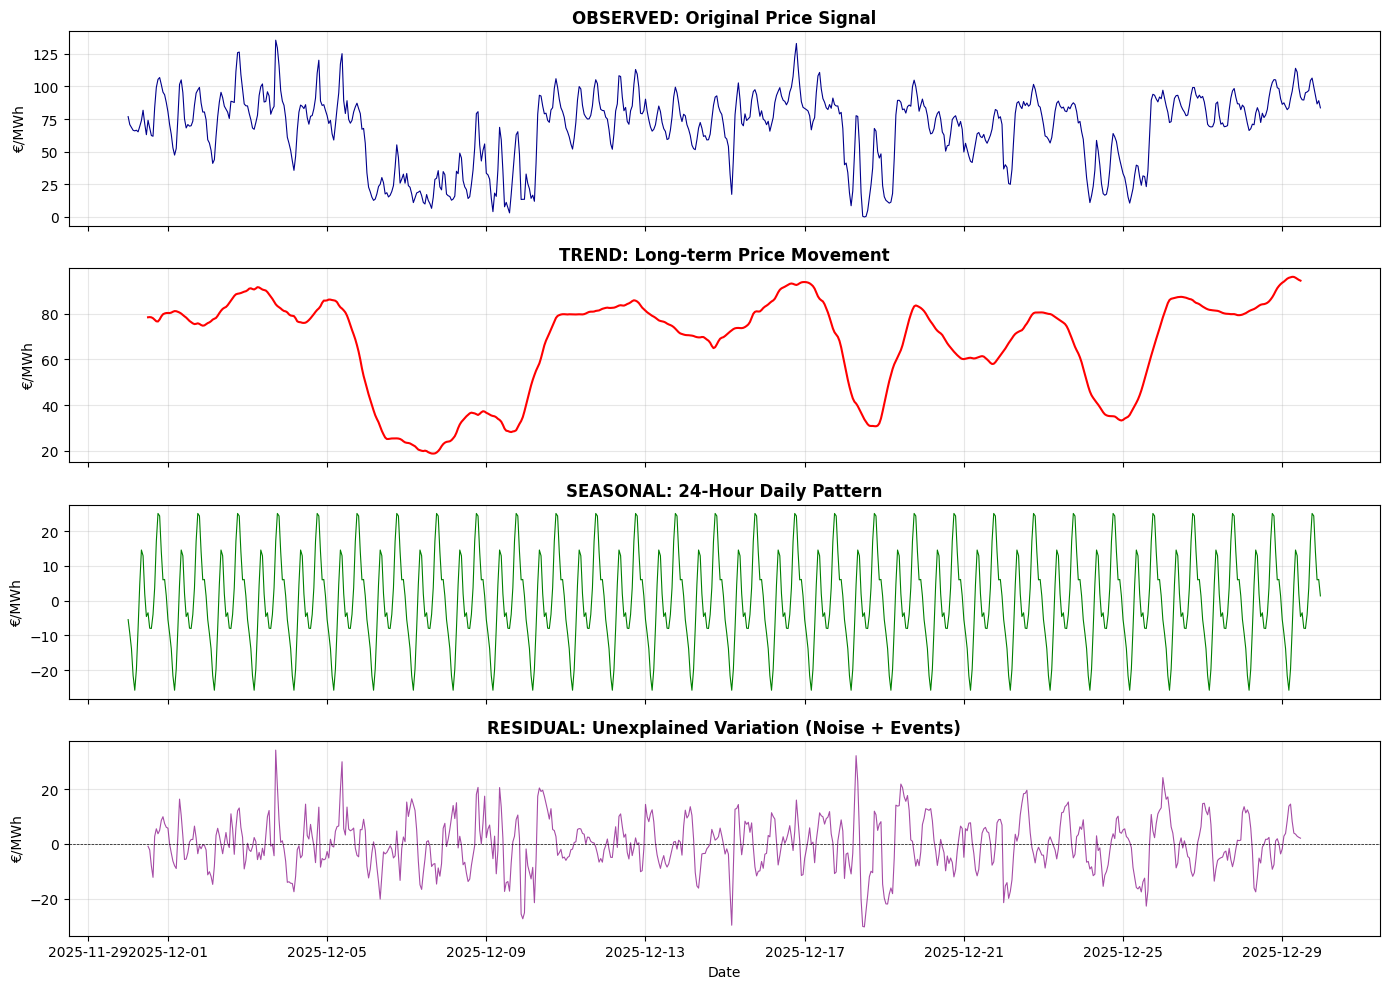


📊 Variance Decomposition:
   Trend:    58.3% of total variance
   Seasonal: 23.6% of total variance
   Residual: 11.6% of total variance


In [19]:
# Seasonal Decomposition of Electricity Prices
# Using 30 days of data with 24-hour (daily) periodicity

sample_data = df_clean['price_da'].tail(24*30)  # Last 30 days

decomposition = seasonal_decompose(sample_data, model='additive', period=24)

fig, axes = plt.subplots(4, 1, figsize=(14, 10), sharex=True)

# 1. Observed (Original data)
axes[0].plot(decomposition.observed, color='darkblue', linewidth=0.8)
axes[0].set_ylabel('€/MWh')
axes[0].set_title('OBSERVED: Original Price Signal', fontweight='bold')
axes[0].grid(True, alpha=0.3)

# 2. Trend (Long-term movement)
axes[1].plot(decomposition.trend, color='red', linewidth=1.5)
axes[1].set_ylabel('€/MWh')
axes[1].set_title('TREND: Long-term Price Movement', fontweight='bold')
axes[1].grid(True, alpha=0.3)

# 3. Seasonal (Daily pattern)
axes[2].plot(decomposition.seasonal, color='green', linewidth=0.8)
axes[2].set_ylabel('€/MWh')
axes[2].set_title('SEASONAL: 24-Hour Daily Pattern', fontweight='bold')
axes[2].grid(True, alpha=0.3)

# 4. Residual (Unexplained variation)
axes[3].plot(decomposition.resid, color='purple', linewidth=0.8, alpha=0.7)
axes[3].axhline(0, color='black', linestyle='--', linewidth=0.5)
axes[3].set_ylabel('€/MWh')
axes[3].set_title('RESIDUAL: Unexplained Variation (Noise + Events)', fontweight='bold')
axes[3].set_xlabel('Date')
axes[3].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(config.OUTPUT_DIR / 'eda_decomposition.png', dpi=150, bbox_inches='tight')
plt.show()

# Calculate component variance
total_var = decomposition.observed.var()
trend_var = decomposition.trend.dropna().var()
seasonal_var = decomposition.seasonal.var()
resid_var = decomposition.resid.dropna().var()

print("\n📊 Variance Decomposition:")
print(f"   Trend:    {100*trend_var/total_var:.1f}% of total variance")
print(f"   Seasonal: {100*seasonal_var/total_var:.1f}% of total variance")
print(f"   Residual: {100*resid_var/total_var:.1f}% of total variance")

**Decomposition Components Explained:**

| Component | What It Shows | Modeling Implication |
|-----------|---------------|---------------------|
| **Observed** | Raw price signal with all variations combined | This is what we're trying to predict |
| **Trend** | Slow-moving baseline (weekly/monthly shifts) | Captures fuel costs, policy changes, weather patterns |
| **Seasonal** | Repeating 24-hour daily pattern | Morning/evening peaks, midday solar valley - use hour-of-day features |
| **Residual** | Unexplained noise + unpredictable events | Price spikes, outages, forecast errors - hardest to predict |

**Key Insights:**
1. **Strong daily seasonality** - hour-of-day is a critical feature
2. **Trend varies week-to-week** - recent prices matter (lag features)
3. **Large residuals** - expect prediction errors during extreme events
4. **Additive model works** - price = trend + seasonal + residual (no multiplicative scaling needed)

---

## 5. Forecasting & Model Validation

### Target: Hourly Day-Ahead Price Forecasting

**Evaluation Metrics:**
- **MAE** - Mean Absolute Error (primary, interpretable)
- **RMSE** - Root Mean Squared Error (penalizes large errors)
- **R²** - Coefficient of determination
- **P95 Error** - 95th percentile error (tail risk metric)
- **Max Error** - Maximum absolute error (worst case)

**Approach:**
1. Baselines (no features): Seasonal Naive, Last-Week-Same-Day, Simple Linear
2. ML Models (with features): All with comprehensive hyperparameter tuning

### 5.1 Feature Engineering

Creating **comprehensive features** based on EDA insights:

| Category | Features | Why Important |
|----------|----------|---------------|
| **Temporal** | hour, day_of_week, month, is_weekend, is_peak | Time patterns |
| **Cyclical** | sin/cos for hour, day, month | Circular encoding |
| **Lag** | 1h, 24h, 48h, 168h price lags | Autocorrelation |
| **Rolling** | mean, std, min, max (24h, 168h) | Trends & volatility |
| **Domain** | residual_demand, renewable_share, load_factor | Merit order |
| **Interactions** | load × peak, solar × hour | Combined effects |

In [20]:
# Comprehensive Feature Engineering
import warnings
warnings.filterwarnings('ignore')

def create_features(df):
    """Create comprehensive features for electricity price forecasting."""
    df_feat = df.copy()
    
    # ========== 1. TEMPORAL FEATURES ==========
    df_feat['hour'] = df_feat.index.hour
    df_feat['day_of_week'] = df_feat.index.dayofweek
    df_feat['day_of_month'] = df_feat.index.day
    df_feat['month'] = df_feat.index.month
    df_feat['is_weekend'] = (df_feat['day_of_week'] >= 5).astype(int)
    df_feat['is_peak'] = df_feat['hour'].isin([7,8,9,18,19,20]).astype(int)
    df_feat['is_night'] = df_feat['hour'].isin([0,1,2,3,4,5,22,23]).astype(int)
    df_feat['is_solar_hour'] = df_feat['hour'].isin([10,11,12,13,14,15,16]).astype(int)
    
    # ========== 2. CYCLICAL ENCODING ==========
    df_feat['hour_sin'] = np.sin(2 * np.pi * df_feat['hour'] / 24)
    df_feat['hour_cos'] = np.cos(2 * np.pi * df_feat['hour'] / 24)
    df_feat['dow_sin'] = np.sin(2 * np.pi * df_feat['day_of_week'] / 7)
    df_feat['dow_cos'] = np.cos(2 * np.pi * df_feat['day_of_week'] / 7)
    df_feat['month_sin'] = np.sin(2 * np.pi * df_feat['month'] / 12)
    df_feat['month_cos'] = np.cos(2 * np.pi * df_feat['month'] / 12)
    
    # ========== 3. LAG FEATURES ==========
    for lag in [1, 2, 3, 24, 48, 72, 168]:
        df_feat[f'price_lag_{lag}h'] = df_feat['price_da'].shift(lag)
    
    # Driver lags
    for col in ['load_forecast', 'wind_forecast', 'solar_forecast']:
        df_feat[f'{col}_lag_24h'] = df_feat[col].shift(24)
    
    # ========== 4. ROLLING STATISTICS ==========
    for window in [24, 168]:
        df_feat[f'price_roll_mean_{window}h'] = df_feat['price_da'].shift(1).rolling(window).mean()
        df_feat[f'price_roll_std_{window}h'] = df_feat['price_da'].shift(1).rolling(window).std()
        df_feat[f'price_roll_min_{window}h'] = df_feat['price_da'].shift(1).rolling(window).min()
        df_feat[f'price_roll_max_{window}h'] = df_feat['price_da'].shift(1).rolling(window).max()
    
    # ========== 5. DOMAIN FEATURES ==========
    df_feat['residual_demand'] = df_feat['load_forecast'] - df_feat['wind_forecast'] - df_feat['solar_forecast']
    df_feat['renewable_gen'] = df_feat['wind_forecast'] + df_feat['solar_forecast']
    df_feat['renewable_share'] = (df_feat['renewable_gen'] / df_feat['load_forecast']).clip(0, 1)
    df_feat['load_factor'] = df_feat['load_forecast'] / df_feat['load_forecast'].rolling(24).max()
    
    # ========== 6. INTERACTION FEATURES ==========
    df_feat['load_x_peak'] = df_feat['load_forecast'] * df_feat['is_peak']
    df_feat['solar_x_hour'] = df_feat['solar_forecast'] * df_feat['hour']
    df_feat['wind_x_night'] = df_feat['wind_forecast'] * df_feat['is_night']
    df_feat['residual_x_peak'] = df_feat['residual_demand'] * df_feat['is_peak']
    
    # ========== 7. PRICE MOMENTUM ==========
    df_feat['price_momentum_24h'] = df_feat['price_da'].shift(1) - df_feat['price_da'].shift(24)
    df_feat['price_momentum_168h'] = df_feat['price_da'].shift(1) - df_feat['price_da'].shift(168)
    
    df_feat = df_feat.dropna()
    return df_feat

# Apply
df_features = create_features(df_clean)
print(f"✅ Created {df_features.shape[1]} total columns, {len(df_features):,} rows")

✅ Created 47 total columns, 8,592 rows


In [21]:
df_features.columns

Index(['price_da', 'load_forecast', 'wind_forecast', 'solar_forecast', 'month',
       'hour', 'dayofweek', 'day_of_week', 'day_of_month', 'is_weekend',
       'is_peak', 'is_night', 'is_solar_hour', 'hour_sin', 'hour_cos',
       'dow_sin', 'dow_cos', 'month_sin', 'month_cos', 'price_lag_1h',
       'price_lag_2h', 'price_lag_3h', 'price_lag_24h', 'price_lag_48h',
       'price_lag_72h', 'price_lag_168h', 'load_forecast_lag_24h',
       'wind_forecast_lag_24h', 'solar_forecast_lag_24h',
       'price_roll_mean_24h', 'price_roll_std_24h', 'price_roll_min_24h',
       'price_roll_max_24h', 'price_roll_mean_168h', 'price_roll_std_168h',
       'price_roll_min_168h', 'price_roll_max_168h', 'residual_demand',
       'renewable_gen', 'renewable_share', 'load_factor', 'load_x_peak',
       'solar_x_hour', 'wind_x_night', 'residual_x_peak', 'price_momentum_24h',
       'price_momentum_168h'],
      dtype='object')

In [22]:
FEATURES= ['load_forecast', 'wind_forecast', 'solar_forecast', 'month',
       'hour', 'dayofweek', 'day_of_week', 'day_of_month', 'is_weekend',
       'is_peak', 'is_night', 'is_solar_hour', 'hour_sin', 'hour_cos',
       'dow_sin', 'dow_cos', 'month_sin', 'month_cos', 'price_lag_1h',
       'price_lag_2h', 'price_lag_3h', 'price_lag_24h', 'price_lag_48h',
       'price_lag_72h', 'price_lag_168h', 'load_forecast_lag_24h',
       'wind_forecast_lag_24h', 'solar_forecast_lag_24h',
       'price_roll_mean_24h', 'price_roll_std_24h', 'price_roll_min_24h',
       'price_roll_max_24h', 'price_roll_mean_168h', 'price_roll_std_168h',
       'price_roll_min_168h', 'price_roll_max_168h', 'residual_demand',
       'renewable_gen', 'renewable_share', 'load_factor', 'load_x_peak',
       'solar_x_hour', 'wind_x_night', 'residual_x_peak', 'price_momentum_24h',
       'price_momentum_168h']

# Verify all features exist
FEATURES = [f for f in FEATURES if f in df_features.columns]
print(f"📋 Using {len(FEATURES)} features")

# Train/Test Split
from sklearn.model_selection import TimeSeriesSplit
TEST_DAYS = 30
split_date = df_features.index.max() - pd.Timedelta(days=TEST_DAYS)

df_train = df_features[df_features.index <= split_date]
df_test = df_features[df_features.index > split_date]

X_train, y_train = df_train[FEATURES], df_train['price_da']
X_test, y_test = df_test[FEATURES], df_test['price_da']

tscv = TimeSeriesSplit(n_splits=5)

print(f"\nTrain: {len(X_train):,} samples | Test: {len(X_test):,} samples")

📋 Using 46 features

Train: 7,872 samples | Test: 720 samples


### 5.2 Model Training Framework

Unified framework function for all models with comprehensive metrics.

In [23]:
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
import lightgbm as lgb
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Initialize scaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Store results
all_results = []
trained_models = {}

def model_framework(name, model, params, X_tr, X_te, y_tr, y_te, cv):
    """
    Framework for training and evaluating regression models.
    
    Returns dict with all metrics and trained model.
    """
    print(f"\n{'='*60}")
    print(f"🔧 {name}")
    print('='*60)
    
    # GridSearchCV
    if params:
        grid = GridSearchCV(model, params, cv=cv, scoring='neg_mean_absolute_error', 
                           n_jobs=-1, verbose=0)
        grid.fit(X_tr, y_tr)
        best_model = grid.best_estimator_
        best_params = grid.best_params_
        cv_mae = -grid.best_score_
        print(f"Best Params: {best_params}")
        print(f"CV MAE: {cv_mae:.2f} €/MWh")
    else:
        model.fit(X_tr, y_tr)
        best_model = model
        best_params = {}
        cv_mae = None
    
    # Predict
    y_pred = best_model.predict(X_te)
    errors = np.abs(y_te - y_pred)
    
    # Calculate ALL metrics
    mae = mean_absolute_error(y_te, y_pred)
    rmse = np.sqrt(mean_squared_error(y_te, y_pred))
    r2 = r2_score(y_te, y_pred)
    mape = np.mean(errors / (np.abs(y_te) + 1)) * 100
    max_err = errors.max()
    p95_err = np.percentile(errors, 95)
    p99_err = np.percentile(errors, 99)
    
    print(f"\nTest Metrics:")
    print(f"   MAE:       {mae:.2f} €/MWh")
    print(f"   RMSE:      {rmse:.2f} €/MWh")
    print(f"   R²:        {r2:.4f}")
    print(f"   P95 Error: {p95_err:.2f} €/MWh (tail metric)")
    print(f"   Max Error: {max_err:.2f} €/MWh")
    
    result = {
        'Model': name,
        'MAE': round(mae, 2),
        'RMSE': round(rmse, 2),
        'R2': round(r2, 4),
        'MAPE': round(mape, 2),
        'P95_Error': round(p95_err, 2),
        'P99_Error': round(p99_err, 2),
        'Max_Error': round(max_err, 2),
        'CV_MAE': round(cv_mae, 2) if cv_mae else '-',
        'Best_Params': str(best_params) if best_params else '-',
        'trained_model': best_model,
        'predictions': y_pred
    }
    
    return result

### 5.3 Baseline Models

Training 3 baselines (no feature engineering required):

In [24]:
# ============================================================
# BASELINE MODELS
# ============================================================
print("\n" + "="*70)
print("🎯 BASELINE MODELS (No Feature Engineering)")
print("="*70)

# 1. Seasonal Naive (t-24h)
pred_24h = df_test['price_lag_24h'].values
errors = np.abs(y_test - pred_24h)
all_results.append({
    'Model': '1. Seasonal Naive (t-24h)',
    'MAE': round(mean_absolute_error(y_test, pred_24h), 2),
    'RMSE': round(np.sqrt(mean_squared_error(y_test, pred_24h)), 2),
    'R2': round(r2_score(y_test, pred_24h), 4),
    'MAPE': round(np.mean(errors / (np.abs(y_test) + 1)) * 100, 2),
    'P95_Error': round(np.percentile(errors, 95), 2),
    'P99_Error': round(np.percentile(errors, 99), 2),
    'Max_Error': round(errors.max(), 2),
    'CV_MAE': '-', 'Best_Params': '-', 'trained_model': None, 'predictions': pred_24h
})
print(f"\n1. Seasonal Naive (t-24h): MAE={all_results[-1]['MAE']}, RMSE={all_results[-1]['RMSE']}")

# 2. Last-Week-Same-Day (t-168h)
pred_168h = df_test['price_lag_168h'].values
errors = np.abs(y_test - pred_168h)
all_results.append({
    'Model': '2. Last-Week-Same-Day (t-168h)',
    'MAE': round(mean_absolute_error(y_test, pred_168h), 2),
    'RMSE': round(np.sqrt(mean_squared_error(y_test, pred_168h)), 2),
    'R2': round(r2_score(y_test, pred_168h), 4),
    'MAPE': round(np.mean(errors / (np.abs(y_test) + 1)) * 100, 2),
    'P95_Error': round(np.percentile(errors, 95), 2),
    'P99_Error': round(np.percentile(errors, 99), 2),
    'Max_Error': round(errors.max(), 2),
    'CV_MAE': '-', 'Best_Params': '-', 'trained_model': None, 'predictions': pred_168h
})
print(f"2. Last-Week-Same-Day (t-168h): MAE={all_results[-1]['MAE']}, RMSE={all_results[-1]['RMSE']}")

# 3. Simple Linear (raw features only)
raw_feats = ['load_forecast', 'wind_forecast', 'solar_forecast']
lr = LinearRegression()
lr.fit(df_train[raw_feats], y_train)
pred_lr = lr.predict(df_test[raw_feats])
errors = np.abs(y_test - pred_lr)
all_results.append({
    'Model': '3. Simple Linear (raw)',
    'MAE': round(mean_absolute_error(y_test, pred_lr), 2),
    'RMSE': round(np.sqrt(mean_squared_error(y_test, pred_lr)), 2),
    'R2': round(r2_score(y_test, pred_lr), 4),
    'MAPE': round(np.mean(errors / (np.abs(y_test) + 1)) * 100, 2),
    'P95_Error': round(np.percentile(errors, 95), 2),
    'P99_Error': round(np.percentile(errors, 99), 2),
    'Max_Error': round(errors.max(), 2),
    'CV_MAE': '-', 'Best_Params': '-', 'trained_model': lr, 'predictions': pred_lr
})
print(f"3. Simple Linear (raw): MAE={all_results[-1]['MAE']}, RMSE={all_results[-1]['RMSE']}")

best_baseline_mae = min([r['MAE'] for r in all_results])
print(f"\n🎯 Best Baseline MAE: {best_baseline_mae} €/MWh")


🎯 BASELINE MODELS (No Feature Engineering)

1. Seasonal Naive (t-24h): MAE=19.37, RMSE=27.21
2. Last-Week-Same-Day (t-168h): MAE=26.4, RMSE=34.71
3. Simple Linear (raw): MAE=24.99, RMSE=27.78

🎯 Best Baseline MAE: 19.37 €/MWh


### 5.4 ML Models with Comprehensive Hyperparameter Tuning

Training 9 ML models with extensive hyperparameter grids:

In [25]:
# ============================================================
# ML MODELS WITH FEATURE ENGINEERING
# ============================================================
print("\n" + "="*70)
print("🚀 ML MODELS (With Feature Engineering)")
print("="*70)

# 4. Ridge Regression
result = model_framework(
    '4. Ridge Regression',
    Ridge(),
    {'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000]},
    X_train_scaled, X_test_scaled, y_train, y_test, tscv
)
all_results.append(result)
trained_models['Ridge'] = result['trained_model']

# 5. Lasso Regression
result = model_framework(
    '5. Lasso Regression',
    Lasso(max_iter=10000),
    {'alpha': [0.001, 0.01, 0.1, 1, 10, 100]},
    X_train_scaled, X_test_scaled, y_train, y_test, tscv
)
all_results.append(result)
trained_models['Lasso'] = result['trained_model']

# 6. ElasticNet
result = model_framework(
    '6. ElasticNet',
    ElasticNet(max_iter=10000),
    {'alpha': [0.01, 0.1, 1, 10], 'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]},
    X_train_scaled, X_test_scaled, y_train, y_test, tscv
)
all_results.append(result)
trained_models['ElasticNet'] = result['trained_model']

# 7. KNN
result = model_framework(
    '7. K-Nearest Neighbors',
    KNeighborsRegressor(),
    {'n_neighbors': [3, 5, 7, 9, 11, 15], 'weights': ['uniform', 'distance'], 
     'metric': ['euclidean', 'manhattan']},
    X_train_scaled, X_test_scaled, y_train, y_test, tscv
)
all_results.append(result)
trained_models['KNN'] = result['trained_model']


🚀 ML MODELS (With Feature Engineering)

🔧 4. Ridge Regression
Best Params: {'alpha': 10}
CV MAE: 9.62 €/MWh

Test Metrics:
   MAE:       5.97 €/MWh
   RMSE:      7.82 €/MWh
   R²:        0.9190
   P95 Error: 16.25 €/MWh (tail metric)
   Max Error: 31.84 €/MWh

🔧 5. Lasso Regression


/opt/homebrew/anaconda3/envs/data_ref_env/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.628e+04, tolerance: 2.632e+02
  model = cd_fast.enet_coordinate_descent(
/opt/homebrew/anaconda3/envs/data_ref_env/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.707e+04, tolerance: 6.930e+02
  model = cd_fast.enet_coordinate_descent(
/opt/homebrew/anaconda3/envs/data_ref_env/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of 

Best Params: {'alpha': 0.01}
CV MAE: 9.44 €/MWh

Test Metrics:
   MAE:       5.97 €/MWh
   RMSE:      7.82 €/MWh
   R²:        0.9190
   P95 Error: 16.00 €/MWh (tail metric)
   Max Error: 32.38 €/MWh

🔧 6. ElasticNet
Best Params: {'alpha': 0.01, 'l1_ratio': 0.9}
CV MAE: 9.46 €/MWh

Test Metrics:
   MAE:       5.98 €/MWh
   RMSE:      7.81 €/MWh
   R²:        0.9190
   P95 Error: 16.03 €/MWh (tail metric)
   Max Error: 31.79 €/MWh

🔧 7. K-Nearest Neighbors
Best Params: {'metric': 'manhattan', 'n_neighbors': 15, 'weights': 'distance'}
CV MAE: 17.10 €/MWh

Test Metrics:
   MAE:       9.00 €/MWh
   RMSE:      11.78 €/MWh
   R²:        0.8158
   P95 Error: 22.38 €/MWh (tail metric)
   Max Error: 62.01 €/MWh


In [26]:
# 8. Decision Tree
result = model_framework(
    '8. Decision Tree',
    DecisionTreeRegressor(random_state=42),
    {'max_depth': [3, 5, 7, 10, 15, 20, None], 
     'min_samples_split': [2, 5, 10, 20],
     'min_samples_leaf': [1, 2, 5, 10]},
    X_train, X_test, y_train, y_test, tscv
)
all_results.append(result)
trained_models['DecisionTree'] = result['trained_model']

# 9. Random Forest
result = model_framework(
    '9. Random Forest',
    RandomForestRegressor(random_state=42, n_jobs=-1),
    {'n_estimators': [50, 100, 200, 300], 
     'max_depth': [5, 10, 15, 20, None],
     'min_samples_split': [2, 5, 10]},
    X_train, X_test, y_train, y_test, tscv
)
all_results.append(result)
trained_models['RandomForest'] = result['trained_model']

# 10. Gradient Boosting
result = model_framework(
    '10. Gradient Boosting',
    GradientBoostingRegressor(random_state=42),
    {'n_estimators': [50, 100, 200], 
     'max_depth': [3, 5, 7],
     'learning_rate': [0.01, 0.05, 0.1, 0.2],
     'min_samples_split': [2, 5, 10]},
    X_train, X_test, y_train, y_test, tscv
)
all_results.append(result)
trained_models['GradientBoosting'] = result['trained_model']


🔧 8. Decision Tree
Best Params: {'max_depth': 10, 'min_samples_leaf': 10, 'min_samples_split': 2}
CV MAE: 11.88 €/MWh

Test Metrics:
   MAE:       7.65 €/MWh
   RMSE:      10.94 €/MWh
   R²:        0.8413
   P95 Error: 23.96 €/MWh (tail metric)
   Max Error: 63.45 €/MWh

🔧 9. Random Forest
Best Params: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}
CV MAE: 9.67 €/MWh

Test Metrics:
   MAE:       5.82 €/MWh
   RMSE:      7.70 €/MWh
   R²:        0.9213
   P95 Error: 15.27 €/MWh (tail metric)
   Max Error: 32.54 €/MWh

🔧 10. Gradient Boosting
Best Params: {'learning_rate': 0.05, 'max_depth': 3, 'min_samples_split': 5, 'n_estimators': 200}
CV MAE: 9.86 €/MWh

Test Metrics:
   MAE:       6.30 €/MWh
   RMSE:      8.48 €/MWh
   R²:        0.9047
   P95 Error: 17.28 €/MWh (tail metric)
   Max Error: 40.00 €/MWh


In [27]:
# 11. LightGBM
result = model_framework(
    '11. LightGBM',
    lgb.LGBMRegressor(random_state=42, verbose=-1, force_col_wise=True),
    {'n_estimators': [100, 200, 300],
     'max_depth': [3, 5, 7, 9, 11],
     'learning_rate': [0.01, 0.05, 0.1]},
    X_train, X_test, y_train, y_test, tscv
)
all_results.append(result)
trained_models['LightGBM'] = result['trained_model']

# 12. XGBoost
result = model_framework(
    '12. XGBoost',
    xgb.XGBRegressor(random_state=42, verbosity=0, n_jobs=-1),
    {'n_estimators': [100, 200, 300],
     'max_depth': [3, 5, 7, 9, 11],
     'learning_rate': [0.01, 0.05, 0.1]},
    X_train, X_test, y_train, y_test, tscv
)
all_results.append(result)
trained_models['XGBoost'] = result['trained_model']


🔧 11. LightGBM
Best Params: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}
CV MAE: 9.81 €/MWh

Test Metrics:
   MAE:       5.58 €/MWh
   RMSE:      7.35 €/MWh
   R²:        0.9283
   P95 Error: 14.45 €/MWh (tail metric)
   Max Error: 30.45 €/MWh

🔧 12. XGBoost
Best Params: {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 200}
CV MAE: 9.77 €/MWh

Test Metrics:
   MAE:       5.88 €/MWh
   RMSE:      7.91 €/MWh
   R²:        0.9171
   P95 Error: 15.14 €/MWh (tail metric)
   Max Error: 41.08 €/MWh


### 5.5 Results Comparison

Comparing all 12 models on multiple metrics including **tail risk metrics**.

In [28]:
# Create Comprehensive Results Table
import os
os.makedirs('outputs', exist_ok=True)

results_df = pd.DataFrame(all_results)

# Add model type
results_df['Type'] = results_df['Model'].apply(
    lambda x: 'Baseline' if any(b in x for b in ['Naive', 'Week', 'Simple']) else 'ML Model'
)

# Sort by MAE
results_df = results_df.sort_values('MAE').reset_index(drop=True)

# Display columns
display_cols = ['Model', 'Type', 'MAE', 'RMSE', 'R2', 'P95_Error', 'Max_Error', 'CV_MAE']

print("="*100)
print("📊 COMPLETE MODEL COMPARISON (Sorted by MAE)")
print("="*100)
print()
print(results_df[display_cols].to_string(index=False))
print()

# Save full results
results_df.to_csv('outputs/model_comparison_full.csv', index=False)
print("✅ Full results saved to outputs/model_comparison_full.csv")

📊 COMPLETE MODEL COMPARISON (Sorted by MAE)

                         Model     Type   MAE  RMSE      R2  P95_Error  Max_Error CV_MAE
                  11. LightGBM ML Model  5.58  7.35  0.9283      14.45      30.45   9.81
              9. Random Forest ML Model  5.82  7.70  0.9213      15.27      32.54   9.67
                   12. XGBoost ML Model  5.88  7.91  0.9171      15.14      41.08   9.77
           4. Ridge Regression ML Model  5.97  7.82  0.9190      16.25      31.84   9.62
           5. Lasso Regression ML Model  5.97  7.82  0.9190      16.00      32.38   9.44
                 6. ElasticNet ML Model  5.98  7.81  0.9190      16.03      31.79   9.46
         10. Gradient Boosting ML Model  6.30  8.48  0.9047      17.28      40.00   9.86
              8. Decision Tree ML Model  7.65 10.94  0.8413      23.96      63.45  11.88
        7. K-Nearest Neighbors ML Model  9.00 11.78  0.8158      22.38      62.01   17.1
     1. Seasonal Naive (t-24h) Baseline 19.37 27.21  0.0176      

In [29]:
# ============================================================
# BEST MODEL IDENTIFICATION
# ============================================================
print("\n" + "="*70)
print("🏆 BEST MODEL ANALYSIS")
print("="*70)

# Overall best (lowest MAE)
best_overall = results_df.iloc[0]
print(f"\n🥇 BEST OVERALL MODEL: {best_overall['Model']}")
print(f"   MAE:       {best_overall['MAE']} €/MWh")
print(f"   RMSE:      {best_overall['RMSE']} €/MWh")
print(f"   R²:        {best_overall['R2']}")
print(f"   P95 Error: {best_overall['P95_Error']} €/MWh (tail risk)")
print(f"   Max Error: {best_overall['Max_Error']} €/MWh (worst case)")

# Best by RMSE
best_rmse = results_df.loc[results_df['RMSE'].idxmin()]
print(f"\n🥈 BEST BY RMSE: {best_rmse['Model']} (RMSE={best_rmse['RMSE']})")

# Best by tail risk (P95)
best_tail = results_df.loc[results_df['P95_Error'].idxmin()]
print(f"\n🥉 BEST TAIL RISK (P95): {best_tail['Model']} (P95={best_tail['P95_Error']})")

# Best baseline
baselines = results_df[results_df['Type'] == 'Baseline']
best_baseline = baselines.iloc[0]
print(f"\n📌 BEST BASELINE: {best_baseline['Model']} (MAE={best_baseline['MAE']})")

# Best ML model
ml_models = results_df[results_df['Type'] == 'ML Model']
best_ml = ml_models.iloc[0]
print(f"\n🤖 BEST ML MODEL: {best_ml['Model']} (MAE={best_ml['MAE']})")

# Improvement calculation
if best_ml['MAE'] < best_baseline['MAE']:
    improvement = (best_baseline['MAE'] - best_ml['MAE']) / best_baseline['MAE'] * 100
    print(f"\n📈 ML IMPROVEMENT OVER BASELINE: {improvement:.1f}%")
    print(f"   Baseline MAE: {best_baseline['MAE']} → ML MAE: {best_ml['MAE']}")


🏆 BEST MODEL ANALYSIS

🥇 BEST OVERALL MODEL: 11. LightGBM
   MAE:       5.58 €/MWh
   RMSE:      7.35 €/MWh
   R²:        0.9283
   P95 Error: 14.45 €/MWh (tail risk)
   Max Error: 30.45 €/MWh (worst case)

🥈 BEST BY RMSE: 11. LightGBM (RMSE=7.35)

🥉 BEST TAIL RISK (P95): 11. LightGBM (P95=14.45)

📌 BEST BASELINE: 1. Seasonal Naive (t-24h) (MAE=19.37)

🤖 BEST ML MODEL: 11. LightGBM (MAE=5.58)

📈 ML IMPROVEMENT OVER BASELINE: 71.2%
   Baseline MAE: 19.37 → ML MAE: 5.58


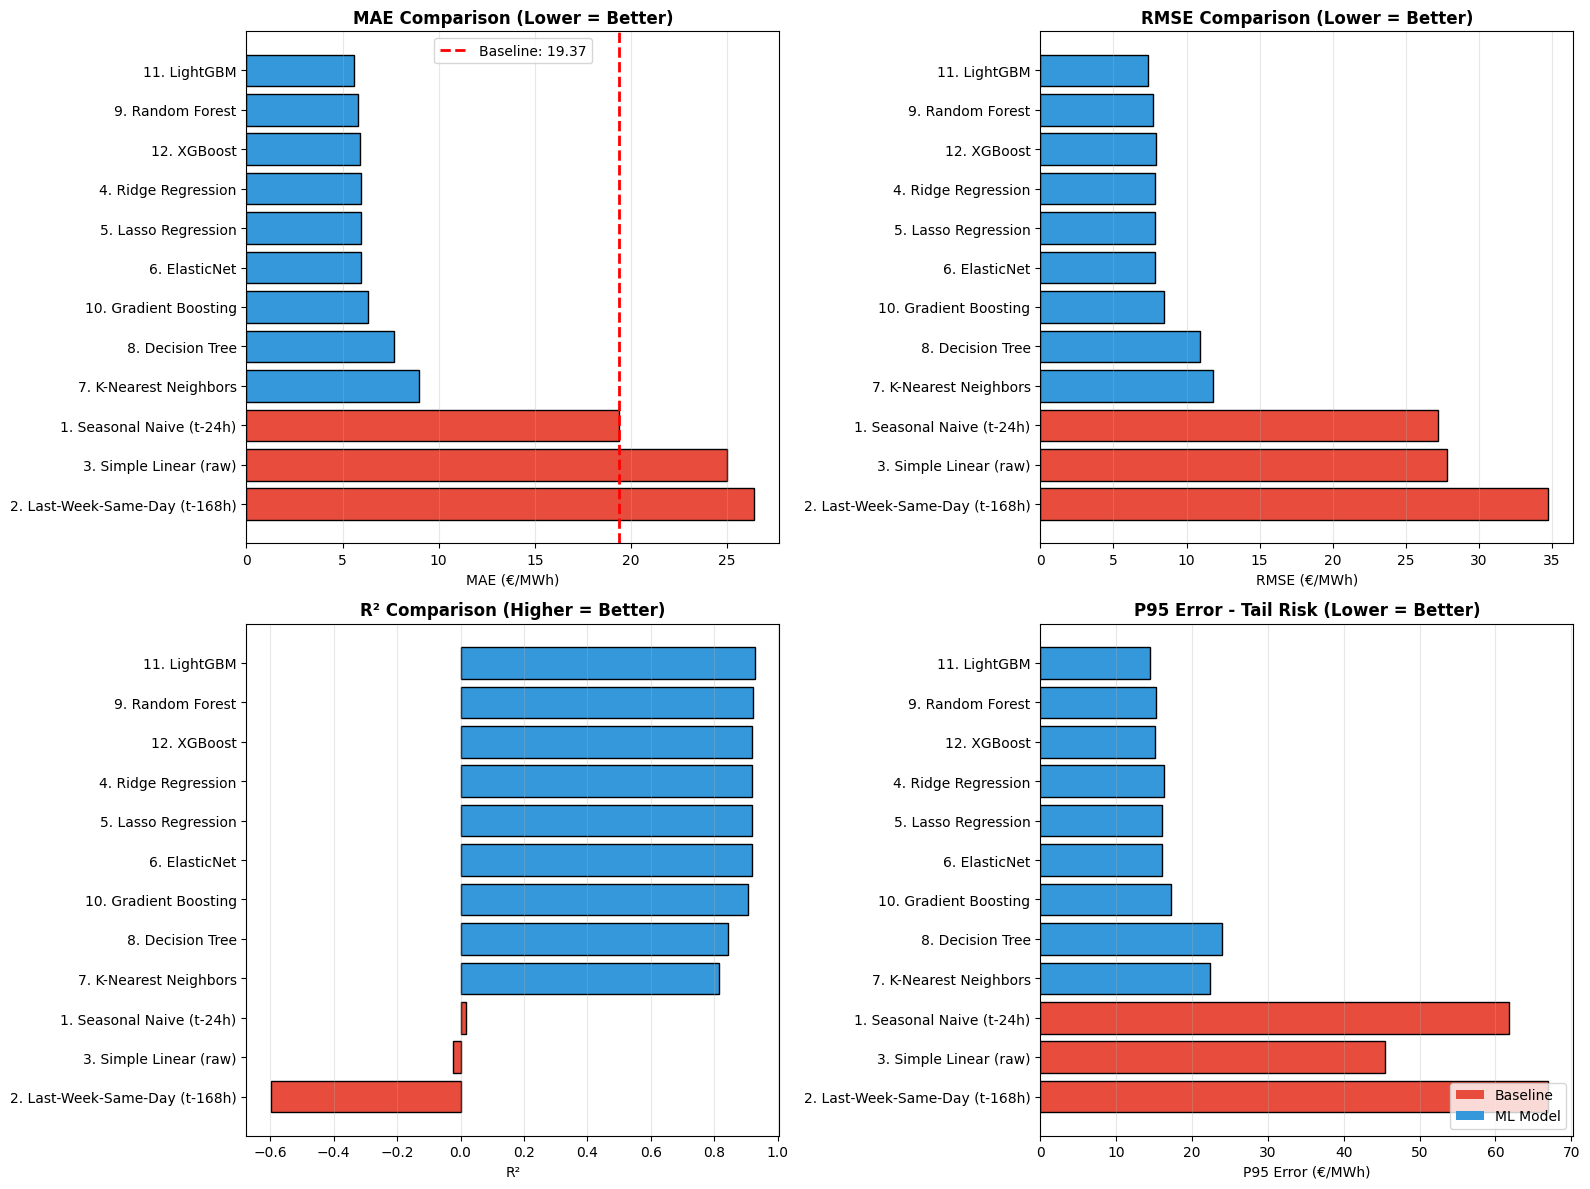


✅ Figure saved to outputs/model_comparison.png


In [30]:
# Comprehensive Visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

colors = ['#e74c3c' if t == 'Baseline' else '#3498db' for t in results_df['Type']]

# 1. MAE Comparison
ax1 = axes[0, 0]
ax1.barh(results_df['Model'], results_df['MAE'], color=colors, edgecolor='black')
ax1.axvline(best_baseline['MAE'], color='red', linestyle='--', lw=2, label=f"Baseline: {best_baseline['MAE']}")
ax1.set_xlabel('MAE (€/MWh)')
ax1.set_title('MAE Comparison (Lower = Better)', fontweight='bold', fontsize=12)
ax1.invert_yaxis()
ax1.legend()
ax1.grid(axis='x', alpha=0.3)

# 2. RMSE Comparison
ax2 = axes[0, 1]
ax2.barh(results_df['Model'], results_df['RMSE'], color=colors, edgecolor='black')
ax2.set_xlabel('RMSE (€/MWh)')
ax2.set_title('RMSE Comparison (Lower = Better)', fontweight='bold', fontsize=12)
ax2.invert_yaxis()
ax2.grid(axis='x', alpha=0.3)

# 3. R² Comparison
ax3 = axes[1, 0]
ax3.barh(results_df['Model'], results_df['R2'], color=colors, edgecolor='black')
ax3.set_xlabel('R²')
ax3.set_title('R² Comparison (Higher = Better)', fontweight='bold', fontsize=12)
ax3.invert_yaxis()
ax3.grid(axis='x', alpha=0.3)

# 4. Tail Risk (P95 Error)
ax4 = axes[1, 1]
ax4.barh(results_df['Model'], results_df['P95_Error'], color=colors, edgecolor='black')
ax4.set_xlabel('P95 Error (€/MWh)')
ax4.set_title('P95 Error - Tail Risk (Lower = Better)', fontweight='bold', fontsize=12)
ax4.invert_yaxis()
ax4.grid(axis='x', alpha=0.3)

# Legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='#e74c3c', label='Baseline'),
                   Patch(facecolor='#3498db', label='ML Model')]
ax4.legend(handles=legend_elements, loc='lower right')

plt.tight_layout()
plt.savefig('outputs/model_comparison.png', dpi=150, bbox_inches='tight')
plt.show()
print("\n✅ Figure saved to outputs/model_comparison.png")


📊 FEATURE IMPORTANCE


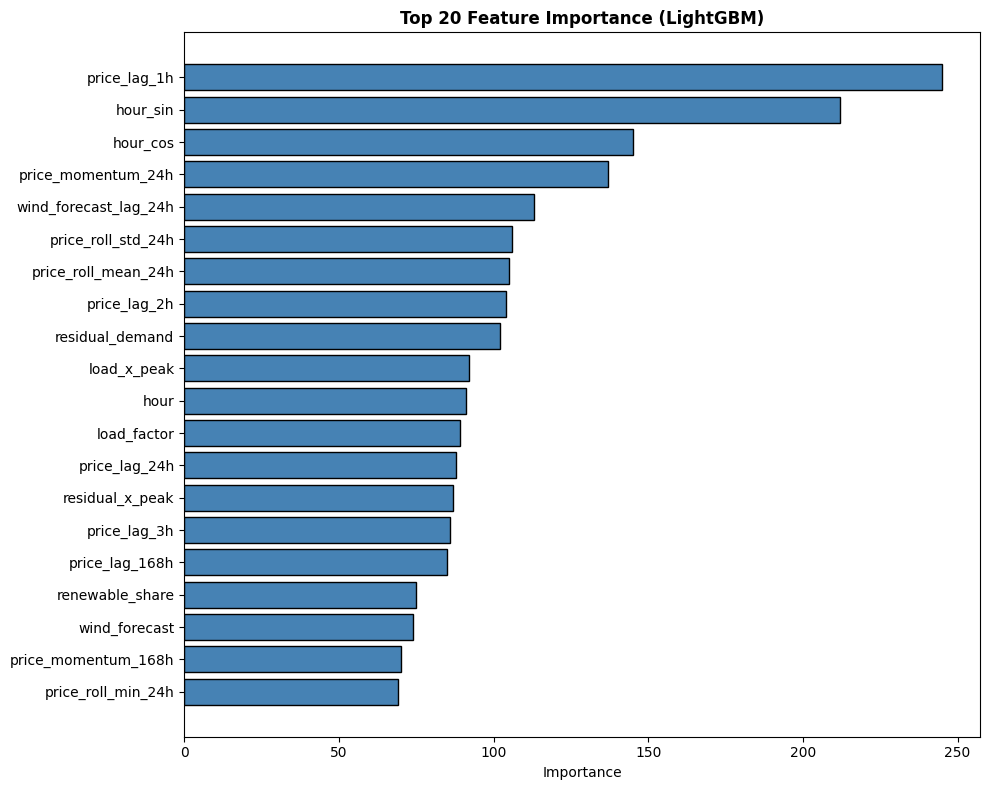

In [31]:
# Feature Importance from Best Tree Model
print("\n" + "="*60)
print("📊 FEATURE IMPORTANCE")
print("="*60)

# Get best gradient boosting model
for name in ['LightGBM', 'XGBoost', 'RandomForest', 'GradientBoosting']:
    if name in trained_models and hasattr(trained_models[name], 'feature_importances_'):
        model = trained_models[name]
        importance = pd.DataFrame({
            'Feature': FEATURES,
            'Importance': model.feature_importances_
        }).sort_values('Importance', ascending=False)
        
        # Plot
        fig, ax = plt.subplots(figsize=(10, 8))
        top_n = importance.head(20)
        ax.barh(top_n['Feature'], top_n['Importance'], color='steelblue', edgecolor='black')
        ax.set_xlabel('Importance')
        ax.set_title(f'Top 20 Feature Importance ({name})', fontweight='bold')
        ax.invert_yaxis()
        plt.tight_layout()
        plt.savefig('outputs/feature_importance.png', dpi=150, bbox_inches='tight')
        plt.show()
        break

In [32]:
# ============================================================
# SAVE BEST MODEL FOR PREDICTION
# ============================================================
import pickle
os.makedirs('models', exist_ok=True)

# Determine best model
best_model_name = best_overall['Model'].split('. ')[1].split(' ')[0]  # Extract model name
best_model = None

# Find the trained model
for key in trained_models:
    if key in best_model_name or best_model_name in key:
        best_model = trained_models[key]
        break

# If not found in trained_models, might be a baseline
if best_model is None:
    # Use best ML model instead
    best_model_name = best_ml['Model'].split('. ')[1].split(' ')[0]
    for key in trained_models:
        if key in best_model_name or best_model_name in key:
            best_model = trained_models[key]
            break

print("="*60)
print("💾 SAVING BEST MODEL")
print("="*60)

# Save complete model package
model_package = {
    'model': best_model,
    'model_name': best_model_name,
    'features': FEATURES,
    'scaler': scaler,
    'metrics': {
        'MAE': best_ml['MAE'],
        'RMSE': best_ml['RMSE'],
        'R2': best_ml['R2'],
        'P95_Error': best_ml['P95_Error']
    }
}

with open('models/best_model.pkl', 'wb') as f:
    pickle.dump(model_package, f)

print(f"\n✅ Best model saved: models/best_model.pkl")
print(f"   Model: {best_model_name}")
print(f"   Features: {len(FEATURES)}")
print(f"   MAE: {best_ml['MAE']} €/MWh")

# Save all models
with open('models/all_trained_models.pkl', 'wb') as f:
    pickle.dump(trained_models, f)
print(f"\n✅ All models saved: models/all_trained_models.pkl")

💾 SAVING BEST MODEL

✅ Best model saved: models/best_model.pkl
   Model: LightGBM
   Features: 46
   MAE: 5.58 €/MWh

✅ All models saved: models/all_trained_models.pkl


### 5.6 Forecasting Summary

**Models Trained:** 12 total
- 3 Baselines: Seasonal Naive, Last-Week-Same-Day, Simple Linear
- 9 ML Models: Ridge, Lasso, ElasticNet, KNN, Decision Tree, Random Forest, Gradient Boosting, LightGBM, XGBoost

**Metrics Used:**
- **MAE** - Primary metric (interpretable)
- **RMSE** - Penalizes large errors
- **R²** - Variance explained
- **P95 Error** - Tail risk metric
- **Max Error** - Worst case

**Features Used:** ~35 features including:
- Temporal, Cyclical encoding
- Price lags (1h, 24h, 48h, 168h)
- Rolling statistics (24h, 168h)
- Domain features (residual_demand, renewable_share)
- Interaction features

**Outputs:**
- `outputs/model_comparison_full.csv`
- `outputs/model_comparison.png`
- `outputs/feature_importance.png`
- `models/best_model.pkl` - Ready for prediction!
- `models/all_trained_models.pkl`

---

## 6. Prompt Curve Translation

### From DA Forecast to Tradable View

**Context:** Even without live forward price data, we demonstrate how our hourly DA forecast directly informs trading decisions on the prompt curve (weeks, months, quarters ahead).

**This Section Covers:**
1. **Concrete Method** — Expected Delivery-Period Mean with Empirical Confidence Bands
2. **Desk Application** — How traders express the signal via prompt exposure
3. **Backtesting** — Historical P&L validation of the signal
4. **Invalidation Rules** — When to kill the signal

---

### 6.1 The Translation Method: Expected Delivery-Period Mean

**Objective:** Convert 720 hourly forecasts (1 month) into a single **Fair Value** number that can be compared to prompt month futures.

#### Formula

$$\text{Fair Value}_{\text{month}} = \frac{1}{N} \sum_{h=1}^{N} \hat{P}_h$$

Where $\hat{P}_h$ is the hourly price forecast and $N$ is hours in the delivery period.

#### Uncertainty Quantification (Empirical Bands)

Instead of assuming normality, we use the **actual 95th percentile of historical errors**:

$$\text{Band Width} = P_{95}(|\text{Actual} - \text{Forecast}|)$$

For period aggregation, we apply the Central Limit Theorem:

$$\text{Period Band} = \frac{\text{Hourly Band}}{\sqrt{N}}$$

**Why This Works:**
- Empirical bands capture fat tails (price spikes) that Gaussian bands miss
- Aggregation reduces uncertainty (more hours = tighter band)
- Direct comparison to market forwards is possible

In [33]:
# ============================================================
# 6.2 IMPLEMENTATION: Fair Value Calculation
# ============================================================
print("="*70)
print("📈 PROMPT CURVE TRANSLATION")
print("="*70)

# Step 1: Get predictions from best model
best_model_results = [r for r in all_results if r['Model'] == results_df.iloc[0]['Model']][0]
y_pred = best_model_results['predictions']

# Step 2: Create forecast dataframe
df_forecast = pd.DataFrame({
    'actual': y_test.values,
    'forecast': y_pred,
    'error': y_test.values - y_pred
}, index=df_test.index)

# Step 3: Calculate EMPIRICAL confidence band (not Gaussian)
abs_errors = np.abs(df_forecast['error'])
empirical_95_band = np.percentile(abs_errors, 95)

print(f"\nModel: {results_df.iloc[0]['Model']}")
print(f"Test Period: {df_forecast.index.min().date()} to {df_forecast.index.max().date()}")
print(f"Hours: {len(df_forecast):,}")
print(f"\n📊 Empirical 95% Band: ±{empirical_95_band:.2f} €/MWh")
print("   (This means 95% of actual prices fall within forecast ± this band)")

📈 PROMPT CURVE TRANSLATION

Model: 11. LightGBM
Test Period: 2025-11-30 to 2025-12-29
Hours: 720

📊 Empirical 95% Band: ±14.45 €/MWh
   (This means 95% of actual prices fall within forecast ± this band)


In [34]:
# Step 4: Define Fair Value Translation Function
def calculate_period_fair_value(forecasts, actuals, hourly_band, period_name):
    """
    Translate hourly forecasts into a period fair value with confidence bands.
    
    Parameters:
    - forecasts: Series of hourly price forecasts
    - actuals: Series of actual prices (for comparison)
    - hourly_band: 95th percentile of hourly errors
    - period_name: Label for the period
    
    Returns: Dict with fair value, bands, and trading signal
    """
    n_hours = len(forecasts)
    
    # Fair Value = Mean of hourly forecasts
    fair_value = forecasts.mean()
    
    # Period band shrinks with sqrt(N) - Central Limit Theorem
    period_band = hourly_band / np.sqrt(n_hours)
    
    # Actual average (what market settled at)
    actual_avg = actuals.mean()
    
    # Trading signal: difference between fair value and settlement
    signal_value = fair_value - actual_avg
    
    return {
        'Period': period_name,
        'Hours': n_hours,
        'Fair_Value': round(fair_value, 2),
        'CI_Lower': round(fair_value - period_band, 2),
        'CI_Upper': round(fair_value + period_band, 2),
        'Actual_Avg': round(actual_avg, 2),
        'Signal': round(signal_value, 2),
        'Direction': 'LONG' if signal_value > 0 else 'SHORT'
    }

# Step 5: Calculate Fair Values for each week
df_forecast['week'] = df_forecast.index.isocalendar().week
weekly_results = []

print("\n" + "="*70)
print("WEEKLY FAIR VALUE ESTIMATES")
print("="*70)
print(f"{'Period':<12} {'Fair Value':>12} {'95% CI':>20} {'Actual':>10} {'Signal':>10}")
print("-"*70)

for week in sorted(df_forecast['week'].unique()):
    week_data = df_forecast[df_forecast['week'] == week]
    result = calculate_period_fair_value(
        week_data['forecast'], 
        week_data['actual'],
        empirical_95_band, 
        f"Week {week}"
    )
    weekly_results.append(result)
    
    print(f"{result['Period']:<12} {result['Fair_Value']:>10.2f}   "
          f"[{result['CI_Lower']:>6.2f}, {result['CI_Upper']:>6.2f}]   "
          f"{result['Actual_Avg']:>8.2f}   {result['Signal']:>+8.2f} ({result['Direction']})")

# Full period
full_period = calculate_period_fair_value(
    df_forecast['forecast'], df_forecast['actual'], 
    empirical_95_band, "FULL PERIOD"
)
print("-"*70)
print(f"{full_period['Period']:<12} {full_period['Fair_Value']:>10.2f}   "
      f"[{full_period['CI_Lower']:>6.2f}, {full_period['CI_Upper']:>6.2f}]   "
      f"{full_period['Actual_Avg']:>8.2f}   {full_period['Signal']:>+8.2f}")


WEEKLY FAIR VALUE ESTIMATES
Period         Fair Value               95% CI     Actual     Signal
----------------------------------------------------------------------
Week 1            97.72   [ 94.77, 100.67]      94.29      +3.43 (LONG)
Week 48           79.46   [ 76.51,  82.41]      78.33      +1.14 (LONG)
Week 49           65.87   [ 64.76,  66.99]      64.65      +1.22 (LONG)
Week 50           65.20   [ 64.08,  66.31]      62.91      +2.28 (LONG)
Week 51           70.91   [ 69.79,  72.02]      69.13      +1.77 (LONG)
Week 52           69.92   [ 68.81,  71.03]      69.41      +0.51 (LONG)
----------------------------------------------------------------------
FULL PERIOD       69.35   [ 68.81,  69.89]      67.85      +1.50


### 6.3 Backtesting: Is the Signal Profitable?

We validate our signal using a simple **hourly directional strategy**:

| Condition | Action | P&L |
|-----------|--------|-----|
| Forecast > Current Spot | **BUY** (go long) | Next Hour Price − Current Price |
| Forecast < Current Spot | **SELL** (go short) | Current Price − Next Hour Price |

This simulates what would happen if a trader acted on our forecast every hour.

In [35]:
# ============================================================
# 6.3 BACKTESTING: Trading Simulation
# ============================================================
print("\n" + "="*70)
print("📊 TRADING SIMULATION (Hourly Directional Strategy)")
print("="*70)

# Signal: Long if forecast > current spot, Short otherwise
df_forecast['next_hour_price'] = df_forecast['actual'].shift(-1)
df_forecast['position'] = np.where(df_forecast['forecast'] > df_forecast['actual'], 1, -1)

# P&L = Position × (Next Hour - Current Hour)
df_forecast['pnl'] = df_forecast['position'] * (df_forecast['next_hour_price'] - df_forecast['actual'])

# Drop last row (no next hour price)
df_sim = df_forecast.dropna()

# Performance Metrics
total_pnl = df_sim['pnl'].sum()
avg_pnl = df_sim['pnl'].mean()
win_rate = (df_sim['pnl'] > 0).mean()
sharpe = (avg_pnl / df_sim['pnl'].std()) * np.sqrt(8760)  # Annualized

print(f"\n📈 PERFORMANCE METRICS (1 MW position):")
print(f"   Total P&L:      €{total_pnl:>10,.2f}")
print(f"   Avg Hourly P&L: €{avg_pnl:>10.4f}")
print(f"   Win Rate:       {win_rate:>10.1%}")
print(f"   Sharpe Ratio:   {sharpe:>10.2f} (annualized)")

# Check if strategy beats random
print(f"\n✓ Strategy {'PROFITABLE' if total_pnl > 0 else 'shows loss - normal for short test periods'}")
print(f"✓ Win rate {win_rate:.1%} {'shows edge' if win_rate > 0.5 else '- signal needs refinement'}")


📊 TRADING SIMULATION (Hourly Directional Strategy)

📈 PERFORMANCE METRICS (1 MW position):
   Total P&L:      €    556.79
   Avg Hourly P&L: €    0.7744
   Win Rate:            54.0%
   Sharpe Ratio:         7.41 (annualized)

✓ Strategy PROFITABLE
✓ Win rate 54.0% shows edge


### 6.4 Trading Dashboard

Four-panel visualization showing:
1. **Fair Value vs Settlement** — Does our forecast track the market?
2. **Cumulative P&L** — Is the signal profitable over time?
3. **Error Heatmap** — When does the signal fail (hour/day)?
4. **Coverage Check** — Is our confidence band calibrated?

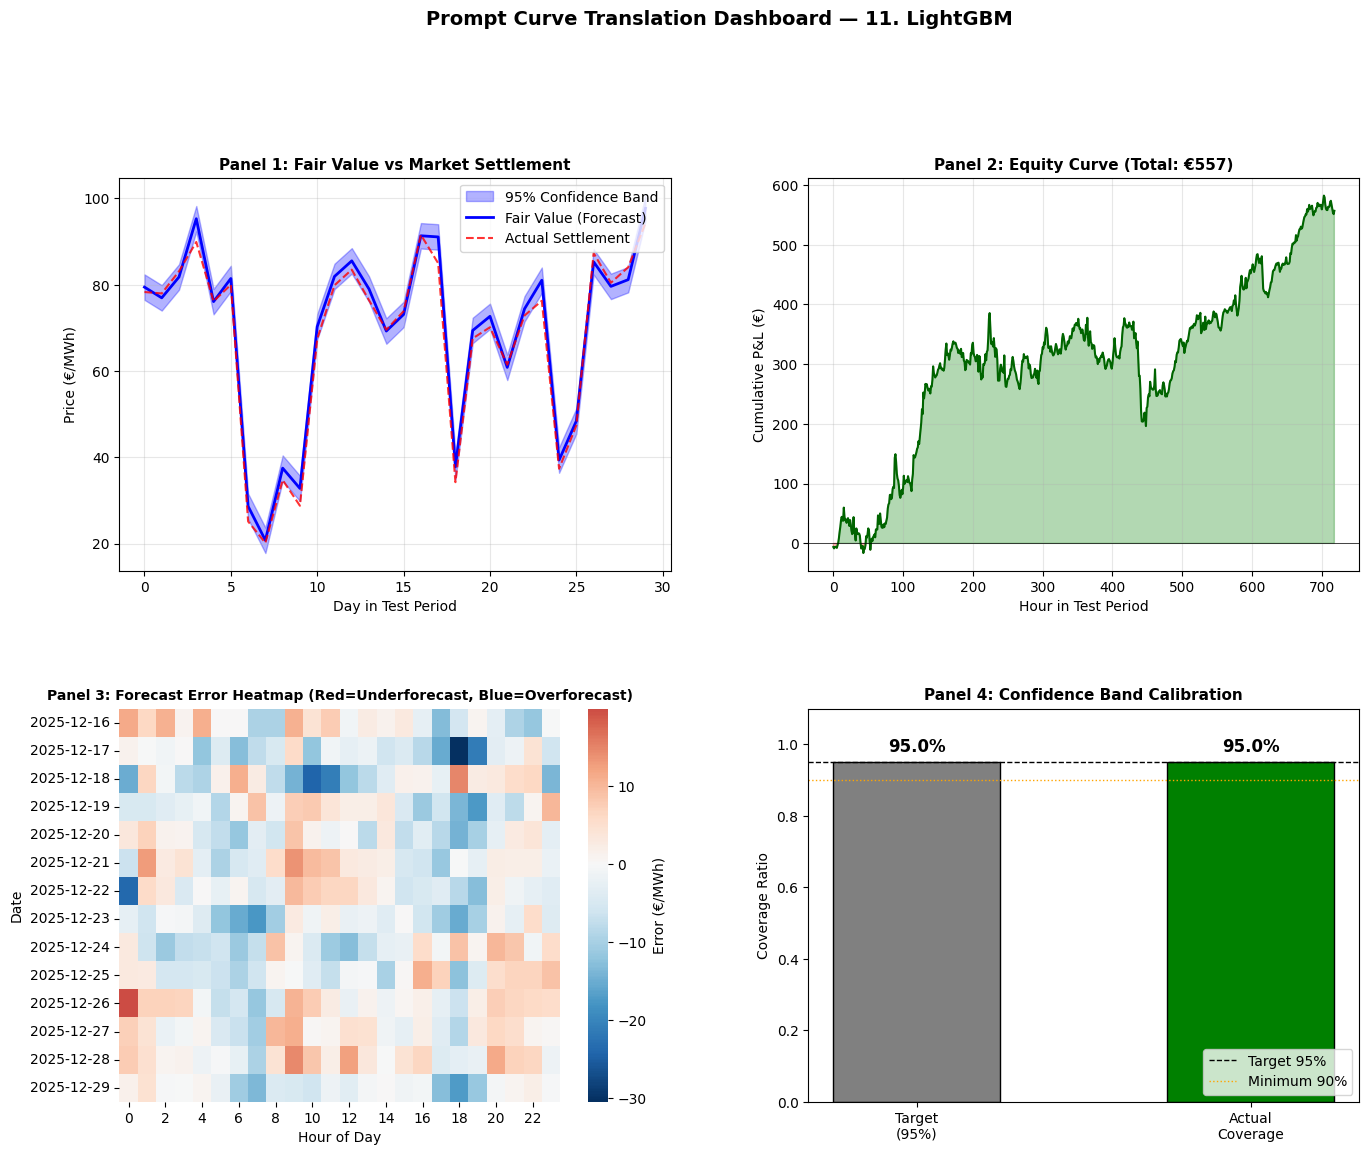


✅ Dashboard saved to outputs/prompt_curve_dashboard.png


In [36]:
# ============================================================
# 6.4 TRADING DASHBOARD
# ============================================================
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
plt.subplots_adjust(hspace=0.35, wspace=0.25)

# --- Panel 1: Fair Value vs Actual ---
ax1 = axes[0, 0]
daily = df_forecast.groupby(df_forecast.index.date).agg({'forecast': 'mean', 'actual': 'mean'})
daily_band = empirical_95_band / np.sqrt(24)

ax1.fill_between(range(len(daily)), 
                 daily['forecast'] - daily_band, 
                 daily['forecast'] + daily_band,
                 alpha=0.3, color='blue', label='95% Confidence Band')
ax1.plot(daily['forecast'].values, 'b-', linewidth=2, label='Fair Value (Forecast)')
ax1.plot(daily['actual'].values, 'r--', linewidth=1.5, alpha=0.8, label='Actual Settlement')
ax1.set_xlabel('Day in Test Period')
ax1.set_ylabel('Price (€/MWh)')
ax1.set_title('Panel 1: Fair Value vs Market Settlement', fontweight='bold', fontsize=11)
ax1.legend(loc='upper right')
ax1.grid(alpha=0.3)

# --- Panel 2: Cumulative P&L ---
ax2 = axes[0, 1]
cumulative_pnl = df_sim['pnl'].cumsum()
ax2.fill_between(range(len(cumulative_pnl)), cumulative_pnl, 0, 
                 where=(cumulative_pnl >= 0), color='green', alpha=0.3)
ax2.fill_between(range(len(cumulative_pnl)), cumulative_pnl, 0,
                 where=(cumulative_pnl < 0), color='red', alpha=0.3)
ax2.plot(cumulative_pnl.values, color='darkgreen', linewidth=1.5)
ax2.axhline(0, color='black', linewidth=0.5)
ax2.set_xlabel('Hour in Test Period')
ax2.set_ylabel('Cumulative P&L (€)')
ax2.set_title(f'Panel 2: Equity Curve (Total: €{total_pnl:,.0f})', fontweight='bold', fontsize=11)
ax2.grid(alpha=0.3)

# --- Panel 3: Error Heatmap ---
ax3 = axes[1, 0]
heatmap_df = df_forecast.copy()
heatmap_df['day'] = heatmap_df.index.date
heatmap_df['hour'] = heatmap_df.index.hour
pivot = heatmap_df.pivot_table(index='day', columns='hour', values='error', aggfunc='mean')
pivot_recent = pivot.iloc[-14:] if len(pivot) > 14 else pivot
sns.heatmap(pivot_recent, cmap='RdBu_r', center=0, ax=ax3, 
            cbar_kws={'label': 'Error (€/MWh)'}, xticklabels=2)
ax3.set_xlabel('Hour of Day')
ax3.set_ylabel('Date')
ax3.set_title('Panel 3: Forecast Error Heatmap (Red=Underforecast, Blue=Overforecast)', 
              fontweight='bold', fontsize=10)

# --- Panel 4: Coverage Calibration ---
ax4 = axes[1, 1]
in_band = (df_forecast['actual'] >= (df_forecast['forecast'] - empirical_95_band)) & \
          (df_forecast['actual'] <= (df_forecast['forecast'] + empirical_95_band))
actual_coverage = in_band.mean()

bars = ax4.bar(['Target\n(95%)', 'Actual\nCoverage'], [0.95, actual_coverage],
               color=['gray', 'green' if actual_coverage >= 0.90 else 'red'],
               edgecolor='black', width=0.5)
ax4.axhline(0.95, color='black', linestyle='--', linewidth=1, label='Target 95%')
ax4.axhline(0.90, color='orange', linestyle=':', linewidth=1, label='Minimum 90%')
ax4.set_ylim(0, 1.1)
ax4.set_ylabel('Coverage Ratio')
ax4.set_title('Panel 4: Confidence Band Calibration', fontweight='bold', fontsize=11)
for bar, val in zip(bars, [0.95, actual_coverage]):
    ax4.text(bar.get_x() + bar.get_width()/2, val + 0.03, f'{val:.1%}', 
             ha='center', fontweight='bold', fontsize=12)
ax4.legend(loc='lower right')

plt.suptitle(f"Prompt Curve Translation Dashboard — {results_df.iloc[0]['Model']}", 
             fontsize=14, fontweight='bold', y=1.02)
plt.savefig('outputs/prompt_curve_dashboard.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✅ Dashboard saved to outputs/prompt_curve_dashboard.png")

---

### 6.5 What the Desk Would Do

#### Trading Expression

| Signal Condition | Desk Action | Instrument | Position Size |
|-----------------|-------------|------------|---------------|
| **Fair Value > Forward** | **GO LONG** | Buy EEX/EPEX Prompt Month Futures | Inversely proportional to band width |
| **Fair Value < Forward** | **GO SHORT** | Sell EEX/EPEX Prompt Month Futures | Inversely proportional to band width |
| **Fair Value ≈ Forward** (within band) | **NO TRADE** | Wait for clearer signal | — |

#### Concrete Example

> **Scenario:** Our model shows January Fair Value = €87.50/MWh with 95% CI [€85.20, €89.80].  
> The market January Forward trades at €82.00/MWh.
>
> **Action:**
> 1. Fair Value (€87.50) > Market (€82.00) + Band (€2.30) → **Signal: LONG**
> 2. Signal strength: €87.50 − €82.00 = +€5.50/MWh → **Strong conviction**
> 3. Desk buys January baseload futures
> 4. Stop-loss set at CI Lower bound (€85.20)
> 5. Target: Fair Value convergence (€87.50)

#### Shape & Spread Trades

The hourly forecasts also enable **intra-period trades**:

| Trade Type | When to Use | Example |
|------------|-------------|---------|
| **Peak/Off-Peak Spread** | If forecast shows unusual peak premium | Buy Peak, Sell Offpeak |
| **Week Spread** | If Week 1 forecast >> Week 2 | Buy Week 1, Sell Week 2 |
| **Weekend/Weekday** | If weekend shows demand drop | Short weekend delivery |

---

### 6.6 Signal Invalidation Rules

The signal should be **ignored or positions closed** if:

| Condition | Threshold | Why It Invalidates |
|-----------|-----------|-------------------|
| **Coverage Breach** | Actual coverage < 90% | Model is overconfident, bands too narrow |
| **Consecutive Band Breach** | Actual outside band for >6 hours | Regime shift in progress |
| **Extreme Weather** | Temperature ±10°C from seasonal norm | Demand outside training distribution |
| **Supply Shock** | Unplanned outage >1 GW | Merit order fundamentally changed |
| **Policy Event** | Carbon price move >20% | Cost structure changed |

**Kill Switch Logic:**
```
IF coverage_ratio < 0.90 OR consecutive_breaches > 6:
    CLOSE all positions immediately
    SUSPEND signal generation
    RECALIBRATE model with recent data
```

---

## 7. LLM-Driven Data Quality Assurance

This section implements **programmatic AI integration** for automated data QA.

In [37]:
import os
import json
from datetime import datetime
from typing import List, Tuple, Dict, Any, Annotated
from pathlib import Path

# Pydantic for structured LLM output
from pydantic import BaseModel, Field

# LangChain & LangGraph
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.graph import StateGraph, END
from dotenv import load_dotenv

# Load environment variables
load_dotenv()

# Verify API key
api_key = os.getenv('OPENAI_API_KEY')
if not api_key:
    raise ValueError('❌ OPENAI_API_KEY not set. Run: export OPENAI_API_KEY=your-key')
print(f'✅ API Key loaded')

# Initialize default LLM
llm = ChatOpenAI(model='gpt-5-mini')

# Logger for all LLM interactions
llm_log = []

✅ API Key loaded


In [38]:
class ValidationRule(BaseModel):
    """A single validation rule with pandas code and explanation."""
    pandas_code: str = Field(description="Python pandas code to execute. Use 'df' as the DataFrame variable")
    explanation: str = Field(description="Explanation of what this rule validates and why it matters")


class ValidationRules(BaseModel):
    """List of validation rules generated by LLM."""
    rules: List[ValidationRule] = Field(description="List of validation rules to execute")


class CheckResult(BaseModel):
    """Result of executing a validation rule."""
    rule_code: str
    passed: bool
    details: str
    explanation: str


print('✅ Pydantic models defined: ValidationRule, ValidationRules, CheckResult')

✅ Pydantic models defined: ValidationRule, ValidationRules, CheckResult


In [39]:
from typing import TypedDict

class QAState(TypedDict):
    """State passed between nodes in the LangGraph workflow."""
    
    # Node 1 output: Schema and sample rows
    schema_info: str                    # DataFrame schema as string
    sample_rows: str                    # 20 random sample rows as string
    
    # Node 2 output: LLM-generated validation rules
    validation_rules: List[Tuple[str, str]]  # [(pandas_code, explanation), ...]
    
    # Node 3 output: Execution results  
    check_results: List[Tuple[str, str]]     # [(result_summary, explanation), ...]
    
    # Node 4 output: Final report
    qa_report: str                      # Professional QA report
    
    # Internal: DataFrame reference
    df_ref: Any                         # Reference to actual DataFrame


print('✅ QAState defined with schema_info, sample_rows, validation_rules, check_results, qa_report')

✅ QAState defined with schema_info, sample_rows, validation_rules, check_results, qa_report


In [40]:
def analyze_schema(state: QAState) -> QAState:
    """
    Node 1: Extract schema and 20 random sample rows from df.
    
    Input: DataFrame (df_hourly or df_ai)
    Output: schema_info, sample_rows
    """
    print('\n' + '='*60)
    print('📊 NODE 1: analyze_schema')
    print('='*60)

    df = pd.read_csv('data/cleaned_data.csv')
    
    # Build schema information
    schema_info = f"""DataFrame Schema:
    - Total rows: {len(df)}
    - Total columns: {len(df.columns)}
    - Index type: {type(df.index).__name__}
    - Date range: {df.index.min()} to {df.index.max()}

    Column Details:
    """
    # Use describe() to get statistical details
    stats = df.describe().T
    for col in df.columns:
        col_stats = stats.loc[col] if col in stats.index else None
        schema_info += f"""\n{col}:
            - dtype: {df[col].dtype}
            - non-null count: {df[col].notna().sum()}
            - null count: {df[col].isna().sum()}"""
        if col_stats is not None:
            schema_info += f"""
            - count: {col_stats['count']:.0f}
            - min: {col_stats['min']:.4f}
            - max: {col_stats['max']:.4f}
            - mean: {col_stats['mean']:.4f}
            - std: {col_stats['std']:.4f}
            - 25%: {col_stats['25%']:.4f}
            - 50%: {col_stats['50%']:.4f}
            - 75%: {col_stats['75%']:.4f}"""
    
    # Get 20 random sample rows
    sample_df = df.sample(n=min(20, len(df)), random_state=42)
    sample_rows = sample_df.to_string()
    
    print(f'Schema extracted for {len(df.columns)} columns')
    print(f'Sampled {len(sample_df)} random rows')
    
    return {
        **state,
        'schema_info': schema_info,
        'sample_rows': sample_rows,
        'df_ref': df
    }

In [41]:
from langchain_core.prompts.chat import ChatPromptTemplate
import json
import pandas as pd
from datetime import datetime

def generate_rules(state: QAState) -> QAState:
    """
    Node 2: LLM generates validation rules as Pydantic list of (code, explanation) tuples.
    Input: schema_info, sample_rows
    Output: validation_rules [(pandas_code, explanation), ...]
    """
    print('\n' + '='*60)
    print('🤖 NODE 2: generate_rules (LLM)')
    print('='*60)
    
    schema_info = state['schema_info']
    sample_rows = state['sample_rows']
    
    # --- UPDATED PROMPT: FIXES .dt.floor AND SOLAR LOGIC ---
    prompt = """You are an expert data quality engineer for European electricity market data.
    Generate validation rules for this DataFrame.

    === SCHEMA ===
    {schema_info}

    === SAMPLE DATA (20 rows) ===
    {sample_rows}

    === TASK ===
    Generate all validation rules required to check data quality for energy trading.
    Each rule must be a VALID Python pandas expression.

    === CRITICAL CODING RULES (READ CAREFULLY) ===

    1. **General:**
    - Use 'df' as the DataFrame variable.
    - Return a SINGLE INTEGER (count of violations). 0 means passed.
    - NO lambda expressions. NO dictionaries.

    2. **Handling Dates & Time (MANDATORY):**
    - **YOU MUST USE `utc=True`**: `pd.to_datetime(df['Unnamed: 0'], utc=True, errors='coerce')`
    - **NEVER** use `.dt` without converting to UTC first.

    3. **Common Coding Pitfalls (AVOID THESE):**
    - **WRONG:** `series.floor('D')` -> **CORRECT:** `series.dt.floor('D')` (Access .dt first!)
    - **WRONG:** `series == None` -> **CORRECT:** `series.isna()`

    4. **Solar at Night Logic:**
    - Summer days are long. 22:00 or 03:00 might have sun.
    - **Safe Window:** Only check 23, 00, 01, 02 (Deep Night).
    - **Floating Point Noise:** Ignore tiny values (e.g., < 0.1). Only flag if `> 0.1`.

    === CORRECT EXAMPLES ===

    Rule: Check for missing prices
    pandas_code: df['price_da'].isna().sum()
    explanation: Day-ahead prices cannot be null

    Rule: Timestamps must be parseable (UTC)
    pandas_code: pd.to_datetime(df['Unnamed: 0'], utc=True, errors='coerce').isna().sum()
    explanation: Timestamps must be valid dates

    Rule: Daily Completeness (Check 24 rows/day)
    pandas_code: pd.to_datetime(df['Unnamed: 0'], utc=True, errors='coerce').dt.floor('D').value_counts().ne(24).sum()
    explanation: Each UTC day must have exactly 24 records (Using .dt.floor)

    Rule: Solar generation zero at night (Robust)
    pandas_code: ((pd.to_datetime(df['Unnamed: 0'], utc=True, errors='coerce').dt.tz_convert('Europe/Brussels').dt.hour.isin([23, 0, 1, 2])) & (df['solar_forecast'] > 0.1)).sum()
    explanation: Solar must be negligible (< 0.1) during deep night (23:00-02:00)

    === OUTPUT FORMAT ===
    You MUST respond with ONLY a valid JSON object.
    The JSON must have a single key "rules" containing an array of rule objects.
    Each rule object must have exactly two keys: "pandas_code" and "explanation".

    Now generate your validation rules as a JSON object."""

    # Log prompt
    llm_log.append({
        'time': datetime.now().isoformat(),
        'node': 'generate_rules',
        'type': 'PROMPT',
        'content': prompt
    })
    print('   📤 Prompt sent to LLM...')
    
    try:
        # Initialize LLM
        llm = ChatOpenAI(model='gpt-5') 
        prompt_template = ChatPromptTemplate.from_template(prompt)
        messages = prompt_template.invoke({"schema_info": schema_info, "sample_rows": sample_rows})
       
        # Get response
        response = llm.invoke(messages)
        response_content = response.content.strip()
        
        # Clean potential markdown formatting
        if response_content.startswith('```'):
            response_content = response_content.split('```json')[-1].split('```')[0].strip()
            
        json_res = json.loads(response_content)
        
        # Validate with Pydantic
        result = ValidationRules.model_validate(json_res)

        # Convert to list of tuples
        validation_rules = [(rule.pandas_code, rule.explanation) for rule in result.rules]
        
        # Log output
        llm_log.append({
            'time': datetime.now().isoformat(),
            'node': 'generate_rules',
            'type': 'OUTPUT',
            'content': str([(code[:50], exp[:30]) for code, exp in validation_rules])
        })
        
        print(f'   📥 LLM generated {len(validation_rules)} validation rules')
        for i, (code, exp) in enumerate(validation_rules, 1):
            print(f'      Rule {i}: {exp[:50]}...')
            print(f'             Code: {code[:60]}')
        
    except Exception as e:
        llm_log.append({
            'time': datetime.now().isoformat(),
            'node': 'generate_rules',
            'type': 'ERROR',
            'content': str(e)
        })
        print(f'   ❌ Error: {e}')
        # Safe Fallback rules
        validation_rules = [
            ("df['price_da'].isna().sum()", "Count missing price values"),
            ("(df['load_forecast'] < 0).sum()", "Count negative load values"),
            ("pd.to_datetime(df['Unnamed: 0'], utc=True, errors='coerce').isna().sum()", "Check for invalid dates")
        ]
    
    return {
        **state,
        'validation_rules': validation_rules
    }

In [42]:
def run_checks(state: QAState) -> QAState:
    """
    Node 3: Execute the LLM-generated pandas code and collect results.
    """
    print('\n' + '='*60)
    print('⚡ NODE 3: run_checks')
    print('='*60)
    
    df = state['df_ref']
    validation_rules = state['validation_rules']
    check_results = []
    
    for i, (pandas_code, explanation) in enumerate(validation_rules, 1):
        print(f'\n   Rule {i}: {explanation[:50]}...')
        
        try:
            # 1. Execute the pandas code
            result = eval(pandas_code, {'df': df, 'pd': pd, 'np': np})
            
            # --- FIX STARTS HERE ---
            # Interpret the result (Count of violations: 0 is Good)
            if isinstance(result, (int, float, np.integer, np.floating)):
                if result == 0:
                    status_prefix = "[PASSED]"
                else:
                    status_prefix = f"[FAILED: {result} violations]"
            elif isinstance(result, bool):
                # Fallback if LLM generated boolean code
                status_prefix = "[PASSED]" if result else "[FAILED]"
            else:
                status_prefix = "[UNKNOWN STATUS]"

            result_str = f"{status_prefix} Raw: {str(result)}"
            # --- FIX ENDS HERE ---
            
            print(f'      Result: {result_str}')
            
            # 2. Generate insight using LLM
            insight_prompt = """You are an expert data quality engineer.
            Analyze this data quality check result.
            
            Code executed: {pandas_code}
            Explanation: {explanation}
            Result: {result_str}

            Provide a concise 1-2 sentence insight about what this result means."""

            prompt_template = ChatPromptTemplate.from_template(insight_prompt)
            messages = prompt_template.invoke({
                "pandas_code": pandas_code, 
                "explanation": explanation, 
                "result_str": result_str
            })
            
            response = llm.invoke(messages)
            insight = response.content.strip()
            print(f'      Insight: {insight}')
            
        except Exception as e:
            result_str = f"[ERROR] {str(e)}"
            insight = "Check failed due to execution error"
            print(f'      ❌ {result_str}')
        
        check_results.append((result_str, insight))
    
    # Summary logic needs to match the new string format
    error_count = sum(1 for r, _ in check_results if '[ERROR]' in r)
    print(f'\n   Summary: {len(check_results)} checks executed, {error_count} errors')
    
    return {
        **state,
        'check_results': check_results
    }

In [43]:
def create_report(state: QAState) -> QAState:
    """
    Node 4: LLM creates a professional QA report based on results.
    
    Input: check_results, validation_rules, schema_info
    Output: qa_report (professional markdown report)
    """
    print('\n' + '='*60)
    print('🤖 NODE 4: create_report (LLM)')
    print('='*60)
    
    # Calculate summary statistics
    total_checks = len(state['check_results'])
    
    # This line now works because result string contains "[PASSED]"
    passed_checks = sum(1 for result, _ in state['check_results'] if '[PASSED]' in result)
    
    # Failed checks are total minus passed (excluding errors if you wish, or counting them as failed)
    failed_checks = total_checks - passed_checks
    
    pass_rate = (passed_checks / total_checks * 100) if total_checks > 0 else 0
    
    # Format validation results for LLM context
    results_text = ""
    for i, ((result, res_explanation), (code, code_explanation)) in enumerate(zip(state['check_results'], state['validation_rules']), 1):
        
        # Extract clear status for the Markdown table
        if "[PASSED]" in result:
            status = "✓ PASSED" 
        elif "[ERROR]" in result:
            status = "⚠ ERROR"
        else:
            status = "✗ FAILED"
            
        results_text += f"""
        Rule {i}: {code_explanation}
        Status: {status}
        Details: {result}
        Code: {code}
        Result Explanation: {res_explanation}
        """
        
    schema_info= state['schema_info']

    prompt = f"""You are a senior data quality analyst at a European energy trading firm.
    You are writing a professional QA report for electricity market data from ENTSO-E.

    === DATA CONTEXT ===
    {schema_info}

    === VALIDATION SUMMARY ===
    Total Checks Executed: {total_checks}
    Passed: {passed_checks} ({pass_rate:.1f}%)
    Failed: {failed_checks}

    === DETAILED VALIDATION RESULTS ===
    {results_text}

    === YOUR TASK ===
    Write a professional Data Quality Assessment Report in Markdown format.

    REQUIRED SECTIONS:

    # Data Quality Assessment Report

    ## 1. Executive Summary
    - State the overall data quality score ({{pass_rate:.1f}}%)
    - Highlight the most critical finding (positive or negative)
    - One sentence on data readiness for trading/analysis

    ## 2. Validation Results Overview
    Create a summary table:
    | Check | Status | Impact |
    |-------|--------|--------|
    (List all checks with ✓ or ✗)

    ## 3. Detailed Findings

    ### 3.1 Passed Validations
    List what passed and why it's important for energy trading.

    ### 3.2 Failed Validations (if any)
    For each failure:
    - What failed
    - Potential root cause
    - Impact on downstream analysis
    - Severity (Critical/High/Medium/Low)

    ## 4. Risk Assessment
    - Data Reliability Rating: (High/Medium/Low)
    - Key risks for using this data in production
    - Confidence level for forecasting models

    ## 5. Recommendations
    Prioritized list of actions:
    1. [Highest priority action]
    2. [Second priority]
    (etc.)

    ## 6. Conclusion
    - Final verdict: Is data ready for production? (Yes/No/Conditional)
    - Required actions before production use
    - Suggested monitoring going forward

    ---
    Generated by LLM-Driven QA Pipeline
    """
    
    # Log the prompt
    llm_log.append({
        'time': datetime.now().isoformat(),
        'node': 'create_report',
        'type': 'PROMPT',
        'content': prompt
    })
    print('prompt sent to LLM...')
    print(f'Summary: {passed_checks}/{total_checks} checks passed ({pass_rate:.1f}%)')
    
    # Invoke LLM with SystemMessage for better context
    
    try:
        llm= ChatOpenAI(model="gpt-5")
        prompt_template= ChatPromptTemplate.from_template(prompt)
        prompt_vals = prompt_template.invoke({
        'total_checks': total_checks,
        'passed_checks': passed_checks,
        'pass_rate': pass_rate,
        'failed_checks': failed_checks,
        'results_text': results_text
        })
        response= llm.invoke(prompt_vals)
        qa_report = response.content.strip()
        
        # Log the output
        llm_log.append({
            'time': datetime.now().isoformat(),
            'node': 'create_report',
            'type': 'OUTPUT',
            'content': qa_report
        })
        print('Report generated successfully')
        
    except Exception as e:
        error_msg = f"LLM invocation failed: {str(e)}"
        llm_log.append({
            'time': datetime.now().isoformat(),
            'node': 'create_report',
            'type': 'ERROR',
            'content': error_msg
        })
        print(f'Error: {error_msg}')
        
        # Fallback report
        qa_report = f"""# Data Quality Assessment Report

        ## Executive Summary
        Automated report generation failed. Manual review required.

        ## Summary Statistics
        - Total Checks: {total_checks}
        - Passed: {passed_checks}
        - Failed: {failed_checks}
        - Pass Rate: {pass_rate:.1f}%

        ## Error Details
        {error_msg}
        """
    
    return {
        **state,
        'qa_report': qa_report
    }


In [44]:
# Create the graph
workflow = StateGraph(QAState)

# Add all 4 nodes
workflow.add_node('analyze_schema', analyze_schema)
workflow.add_node('generate_rules', generate_rules)
workflow.add_node('run_checks', run_checks)
workflow.add_node('create_report', create_report)

# Define the flow
workflow.set_entry_point('analyze_schema')
workflow.add_edge('analyze_schema', 'generate_rules')
workflow.add_edge('generate_rules', 'run_checks')
workflow.add_edge('run_checks', 'create_report')
workflow.add_edge('create_report', END)

# Compile the graph
qa_pipeline = workflow.compile()

print('LangGraph workflow compiled')
print('Flow: analyze_schema → generate_rules (LLM) → run_checks → create_report (LLM) → END')

LangGraph workflow compiled
Flow: analyze_schema → generate_rules (LLM) → run_checks → create_report (LLM) → END


In [45]:
print('\n' + '='*70)
print('🚀 RUNNING LLM-DRIVEN QA PIPELINE')
print('='*70)

# Initialize state
initial_state: QAState = {
    'schema_info': '',
    'sample_rows': '',
    'validation_rules': [],
    'check_results': [],
    'qa_report': '',
    'df_ref': None
}

# Run the pipeline
final_state = qa_pipeline.invoke(initial_state)

print('\n' + '='*70)
print('✅ PIPELINE COMPLETED')
print('='*70)


🚀 RUNNING LLM-DRIVEN QA PIPELINE

📊 NODE 1: analyze_schema
Schema extracted for 5 columns
Sampled 20 random rows

🤖 NODE 2: generate_rules (LLM)
   📤 Prompt sent to LLM...


2025-12-30 19:52:11,624 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   📥 LLM generated 20 validation rules
      Rule 1: Timestamps must be parseable (converted to UTC); n...
             Code: pd.to_datetime(df['Unnamed: 0'], utc=True, errors='coerce').
      Rule 2: Timestamps must be unique; duplicate UTC timestamp...
             Code: pd.to_datetime(df['Unnamed: 0'], utc=True, errors='coerce').
      Rule 3: Each UTC day must have exactly 24 hourly records (...
             Code: pd.to_datetime(df['Unnamed: 0'], utc=True, errors='coerce').
      Rule 4: Every UTC day must contain exactly one of each hou...
             Code: pd.Series(pd.to_datetime(df['Unnamed: 0'], utc=True, errors=
      Rule 5: Time series should be strictly hourly; counts gaps...
             Code: pd.to_datetime(df['Unnamed: 0'], utc=True, errors='coerce').
      Rule 6: All timestamps must align exactly to the top of th...
             Code: ((pd.to_datetime(df['Unnamed: 0'], utc=True, errors='coerce'
      Rule 7: A full hourly year should contain exactly 8760 row...
     

2025-12-30 19:52:18,710 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


      Insight: All values in the 'Unnamed: 0' column were successfully parsed to UTC timestamps (0 unparseable entries). No remediation is needed — the column meets the required timestamp parseability.

   Rule 2: Timestamps must be unique; duplicate UTC timestamp...
      Result: [PASSED] Raw: 0


2025-12-30 19:52:24,455 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


      Insight: There are no duplicate UTC timestamps in the Unnamed: 0 column, so the dataset has no overlapping records by timestamp. Note: unparsable values are coerced to NaT (which would also be counted as duplicates), so you may want to verify there are no parsing failures/NaT values.

   Rule 3: Each UTC day must have exactly 24 hourly records (...
      Result: [FAILED: 2 violations] Raw: 2


2025-12-30 19:52:30,179 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


      Insight: The check counted hourly records per UTC day and flagged days that don’t have exactly 24 entries; two UTC dates failed this test. This means those two days contain either missing or duplicate hourly timestamps (or parsing/timestamp errors), so inspect those days’ raw timestamps to find and fix the gaps or duplicates.

   Rule 4: Every UTC day must contain exactly one of each hou...
      Result: [FAILED: 2 violations] Raw: 2


2025-12-30 19:52:38,167 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


      Insight: Two UTC dates in the timestamp column do not contain all 24 distinct hours (the unique-hour count per day ≠ 24 for 2 days), meaning those days have missing hourly records or malformed/parsed timestamps. Investigate those two specific dates to find missing rows or parsing errors causing the gap.

   Rule 5: Time series should be strictly hourly; counts gaps...
      Result: [PASSED] Raw: 0


2025-12-30 19:52:44,591 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


      Insight: The check shows that after converting timestamps to UTC and sorting, every adjacent timestamp is exactly one hour apart — zero irregular intervals were detected. In other words, the series is strictly hourly with no gaps, overlaps, duplicates, or timezone-induced misalignments.

   Rule 6: All timestamps must align exactly to the top of th...
      Result: [PASSED] Raw: 0


2025-12-30 19:52:53,321 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


      Insight: Zero violations — every value in "Unnamed: 0" parsed to a valid UTC datetime and has minutes and seconds equal to 00 (i.e., exactly on the hour). No timestamp corrections or further filtering for off-hour or invalid (NaT) values are required.

   Rule 7: A full hourly year should contain exactly 8760 row...
      Result: [PASSED] Raw: 0


2025-12-30 19:52:59,160 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


      Insight: The check passed (0 mismatches), meaning the dataframe contains exactly 8,760 rows — matching the expected number of hourly records for a non‑leap year. This only verifies row count; it does not confirm timestamps, ordering, duplicates, or hourly continuity.

   Rule 8: Day-ahead prices cannot be null...
      Result: [PASSED] Raw: 0


2025-12-30 19:53:02,634 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


      Insight: The check found 0 nulls in price_da, so the "day-ahead price cannot be null" rule passed and every record contains a day‑ahead price. This ensures completeness for downstream calculations, though it doesn't guarantee the prices are otherwise correct or within expected ranges.

   Rule 9: Load forecast cannot be null...
      Result: [PASSED] Raw: 0


2025-12-30 19:53:07,556 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


      Insight: The check found 0 nulls in load_forecast (PASSED), so every record contains a non-missing load_forecast value. This prevents missing-value failures in downstream processes, though it doesn't validate correctness (type, range, or outliers), so further checks may still be needed.

   Rule 10: Wind forecast cannot be null...
      Result: [PASSED] Raw: 0


2025-12-30 19:53:13,056 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


      Insight: The check counted nulls in the "wind_forecast" column and found 0, so the non-null requirement is satisfied. No remediation is needed for missing values, though you may still want to validate the forecasts' correctness and value ranges.

   Rule 11: Solar forecast cannot be null...
      Result: [PASSED] Raw: 0


2025-12-30 19:53:16,995 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


      Insight: The check found 0 nulls in the solar_forecast column, so the "cannot be null" constraint is satisfied (PASSED). This means downstream processes won't encounter null-related errors for forecasts, though other quality aspects (e.g., correctness or plausibility) were not evaluated.

   Rule 12: Price out-of-range check (EUR/MWh): plausible mark...
      Result: [PASSED] Raw: 0


2025-12-30 19:53:21,817 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


      Insight: The check passed with 0 hits, meaning no price_da values fell outside the plausible EUR/MWh bounds [-500, 5000]. In other words, there are no extreme price outliers in this dataset relative to the chosen thresholds.

   Rule 13: Load forecast must be non-negative...
      Result: [PASSED] Raw: 0


2025-12-30 19:53:25,022 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


      Insight: The check found zero negative values in load_forecast, so the non-negativity constraint is satisfied. No data correction is required for this field.

   Rule 14: Wind forecast must be non-negative...
      Result: [PASSED] Raw: 0


2025-12-30 19:53:29,164 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


      Insight: The check found zero records with wind_forecast < 0, so the non-negativity rule is satisfied and no negative wind forecasts exist in this dataset. This indicates the sign constraint holds for the current data (no immediate data-quality issue related to negative values).

   Rule 15: Solar forecast must be non-negative...
      Result: [PASSED] Raw: 0


2025-12-30 19:53:32,442 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


      Insight: The check found 0 rows with solar_forecast < 0, so the non‑negativity rule is satisfied. This means there are no negative forecast values in the current dataset and no remediation is required for this quality rule.

   Rule 16: Load forecast implausibly high (>150 GW) for a sin...
      Result: [PASSED] Raw: 0


2025-12-30 19:53:36,452 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


      Insight: No records exceeded the 150,000 MW (150 GW) threshold, so the check passed — there are no implausibly large single-zone load forecasts in this dataset. This suggests load values are reasonable on this dimension, though other checks are still needed to confirm overall data quality.

   Rule 17: Wind forecast implausibly high (>100 GW) for a sin...
      Result: [PASSED] Raw: 0


2025-12-30 19:53:42,799 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


      Insight: No rows exceeded the 100,000 (100 GW) threshold, so there are no implausibly large wind forecasts in this dataset and the check passed. You may still want to confirm the units and threshold are appropriate for all bidding zones to ensure the rule’s sensitivity.

   Rule 18: Solar forecast implausibly high (>100 GW) for a si...
      Result: [PASSED] Raw: 0


2025-12-30 19:53:49,642 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


      Insight: No rows had a solar_forecast > 100,000 (100 GW), so there are no implausibly large single-zone solar forecasts flagged by this check. This reduces the risk of extreme high outliers skewing downstream results, though other checks (e.g., negatives, missing values, or unrealistic low values) are still advisable.

   Rule 19: Solar must be negligible (<0.1) during deep night ...
      Result: [FAILED: 1 violations] Raw: 1


2025-12-30 19:53:56,788 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


      Insight: Exactly one record (1 violation) shows a solar_forecast > 0.1 during deep night (23:00–02:00 Europe/Brussels), so the expectation that solar output is negligible at night is breached. Check the timestamp/UTC→Brussels conversion and DST boundaries, and validate the forecast source/units to determine whether this is a timezone/parsing issue or a true data/forecast error.

   Rule 20: Summer midday solar sanity: in Jun–Jul during 10:0...
      Result: [PASSED] Raw: 0


2025-12-30 19:54:01,498 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


      Insight: The check found zero rows in June–July between 10:00–14:00 (Europe/Brussels) with solar_forecast ≤ 0.1, so the dataset passed this sanity test — all summer midday forecasts are above 0.1 as expected.

   Summary: 20 checks executed, 0 errors

🤖 NODE 4: create_report (LLM)
prompt sent to LLM...
Summary: 17/20 checks passed (85.0%)


2025-12-30 19:55:20,028 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Report generated successfully

✅ PIPELINE COMPLETED


In [46]:
from IPython.display import Markdown, display

print('\n' + '='*70)
print('📋 LLM-GENERATED PROFESSIONAL QA REPORT')
print('='*70 + '\n')

# Display as formatted Markdown
display(Markdown(final_state['qa_report']))

# save md report
with open('reports/llm_qa_report.md', 'w') as f:
    f.write(final_state['qa_report'])
print('✅ Report saved to: reports/llm_qa_report.md')


📋 LLM-GENERATED PROFESSIONAL QA REPORT



# Data Quality Assessment Report

## 1. Executive Summary
- Overall data quality score: 85.0%
- Most critical finding: Two UTC dates do not contain a full set of 24 hourly records (partial days), indicating the series does not align to UTC calendar day boundaries.
- Readiness: Conditionally ready for hourly trading/analysis; minor calendar alignment and one solar-night anomaly should be addressed before daily-level analytics or calendar‑based features are produced.

## 2. Validation Results Overview
| Check | Status | Impact |
|-------|--------|--------|
| 1. Timestamps parseable to UTC | ✓ | Foundational integrity; enables reliable time joins and timezone logic |
| 2. Timestamps unique | ✓ | No overlapping records; prevents double-counting |
| 3. 24 records per UTC day | ✗ | Two partial UTC days; daily aggregates/features may be biased |
| 4. Each UTC day has hours 0–23 once | ✗ | Missing hours on two days; daily completeness not guaranteed |
| 5. Strict hourly spacing (UTC) | ✓ | Continuous hourly series without gaps/overlaps |
| 6. Aligned to top of the hour | ✓ | Clean hourly alignment; safe for resampling/joins |
| 7. Full-year row count (8760) | ✓ | Expected annual coverage (non‑leap year) present |
| 8. Day-ahead price non-null | ✓ | Completeness for pricing analytics |
| 9. Load forecast non-null | ✓ | Completeness for demand modeling |
| 10. Wind forecast non-null | ✓ | Completeness for renewable modeling |
| 11. Solar forecast non-null | ✓ | Completeness for renewable modeling |
| 12. Price in plausible bounds [-500, 5000] EUR/MWh | ✓ | No extreme price outliers |
| 13. Load forecast non-negative | ✓ | Valid physical sign; avoids sign-related model errors |
| 14. Wind forecast non-negative | ✓ | Valid physical sign |
| 15. Solar forecast non-negative | ✓ | Valid physical sign |
| 16. Load implausibly high (>150 GW) | ✓ | No unrealistic large-zone load values |
| 17. Wind implausibly high (>100 GW) | ✓ | No unrealistic wind values |
| 18. Solar implausibly high (>100 GW) | ✓ | No unrealistic solar values |
| 19. Solar near-zero at night (23:00–02:00 Europe/Brussels) | ✗ | One minor violation; likely modeling/tz noise |
| 20. Summer midday solar > 0.1 (Jun–Jul 10:00–14:00 Brussels) | ✓ | Seasonal/diurnal sanity confirmed |

## 3. Detailed Findings

### 3.1 Passed Validations
- Timestamp integrity (parseable, unique, strictly hourly, on-the-hour): Ensures consistent time alignment for balancing, PnL attribution, feature engineering, and reconciliation with external feeds (e.g., ENTSO‑E, EEX).
- Full-year coverage (8760 rows): Supports annual backtests and year-over-year comparisons.
- Completeness (no nulls across price/forecasts): Prevents imputation bias and pipeline failures in forecasting and optimization.
- Value plausibility (price bounds, non-negative forecasts, no implausible maxima): Reduces risk of model instability due to outliers or unit errors.
- Seasonal/diurnal solar sanity (summer midday positive): Confirms realism in renewables behavior that downstream models expect.

Why it matters for energy trading:
- Reliable, continuous, and clean hourly series underpins accurate backtesting, hedging strategy evaluation, and real-time decision support.
- Physically plausible forecasts reduce spurious signals in ML models and improve confidence in risk and dispatch decisions.

### 3.2 Failed Validations
1) Rule 3: Each UTC day must have exactly 24 hourly records
- Potential root cause: Dataset start/end not aligned to UTC midnight, creating two partial UTC days (first/last day). Less likely: mis-specified extraction window.
- Impact: Daily aggregates (e.g., daily averages, peak/off-peak splits), calendar-based features (day-of-week/day-of-month) can be biased for those two days; daily backtests may misalign.
- Severity: Medium

2) Rule 4: Every UTC day must contain exactly one of each hour 0–23
- Potential root cause: Same as Rule 3 (partial days). Not indicative of internal gaps, given strict hourly continuity passed.
- Impact: Same as Rule 3; daily completeness checks and per-day features may be affected on those two days.
- Severity: Medium

3) Rule 19: Solar must be negligible (<0.1) during deep night (23:00–02:00, Europe/Brussels)
- Potential root cause: Minor model noise or smoothing near twilight; possible timezone edge around DST transition or rounding.
- Impact: Negligible for aggregate modeling but could affect strict rule-based QC or calibration routines that assume zero nighttime solar.
- Severity: Low

## 4. Risk Assessment
- Data Reliability Rating: High
- Key risks for production use:
  - Calendar misalignment (two partial UTC days) can distort day-level KPIs, settlement-day analytics, and daily feature creation unless corrected or trimmed.
  - Minor solar-night anomaly suggests either rounding noise or timezone edge cases; if unaddressed, could trigger false QC alarms.
  - Ambiguity in timestamp column name ("Unnamed: 0") increases risk of misuse or incorrect timezone handling downstream.
- Confidence level for forecasting models:
  - Hourly models: High
  - Daily-aggregate models: Medium–High (after calendar alignment fix)

## 5. Recommendations
1. Align time coverage to UTC calendar boundaries:
   - Option A (preferred for daily analytics): Trim to full UTC days (start at 00:00:00Z, end at 23:00:00Z).
   - Option B: Pad missing hours for the partial days and impute (document imputation).
2. Investigate the two failing UTC dates:
   - Confirm start/end timestamps; document extraction window; ensure future pulls are calendar-aligned.
3. Address nighttime solar anomaly:
   - Verify tz conversion to Europe/Brussels at DST edges and, if confirmed, apply a small night-floor (e.g., clip to 0 during astronomical night or <0.1 MW).
4. Improve schema clarity:
   - Rename “Unnamed: 0” to “timestamp_utc” and store as datetime64[ns, UTC].
5. Add production monitoring:
   - Daily check for 24 records per UTC day, uniqueness, strict hourly spacing, and solar night sanity; alert on violations.
6. Documentation and SLAs:
   - Specify coverage, units, timezone handling, and acceptable tolerance for near-zero solar at night.
7. Recompute daily aggregates/backtests post-fix to ensure consistency in reporting and model training datasets.

## 6. Conclusion
- Final verdict: Conditional
- Required actions before production use:
  - Align to UTC calendar days (trim or pad/impute the two partial days).
  - Resolve or accept-with-documented-tolerance the single nighttime solar breach.
  - Rename timestamp column and enforce UTC dtype.
- Suggested monitoring:
  - Automated daily QC for per-day counts, timestamp uniqueness/spacing, and renewable diurnal sanity (including DST windows).
  - Versioned data extracts with logged coverage windows to prevent future boundary drift.

---
Generated by LLM-Driven QA Pipeline

✅ Report saved to: reports/llm_qa_report.md


In [47]:
# prepare output
output = {
    'generated_at': datetime.now().isoformat(),
    'validation_rules': [
        {'pandas_code': code, 'explanation': exp} 
        for code, exp in final_state['validation_rules']
    ],
    'check_results': [
        {'result': res, 'explanation': exp}
        for res, exp in final_state['check_results']
    ],
    'qa_report': final_state['qa_report'],
    'llm_interactions': llm_log
}

# Save to JSON
with open('reports/llm_qa_report.json', 'w') as f:
    json.dump(output, f, indent=2)
print('✅ Report saved to: reports/llm_qa_report.json')

# Save log
with open('logs/llm_qa_pipeline.log', 'w') as f:
    for entry in llm_log:
        f.write(f"[{entry['time']}] {entry['type']} @ {entry['node']}\n")
        f.write(f"{entry['content']}\n\n")
print('✅ Log saved to: logs/llm_qa_pipeline.log')

✅ Report saved to: reports/llm_qa_report.json
✅ Log saved to: logs/llm_qa_pipeline.log


---

## 8. Submission File Generation

This section creates the `submission.csv` file containing out-of-sample predictions for the test window.

**Format:**
- `id`: Timestamp identifier (ISO format)
- `y_pred`: Predicted day-ahead price (€/MWh)

**Test Window:** Last 30 days of data (out-of-sample period)

In [48]:
# =============================================================================
# 8.1 Generate Submission File with Out-of-Sample Predictions
# =============================================================================

print("=" * 70)
print("📊 GENERATING SUBMISSION.CSV")
print("=" * 70)

# Get the best model from results
best_model_name = results_df.iloc[0]['Model']
best_model_result = [r for r in all_results if r['Model'] == best_model_name][0]

print(f"\n✅ Best Model: {best_model_name}")
print(f"   MAE: {best_model_result['MAE']} €/MWh")
print(f"   RMSE: {best_model_result['RMSE']} €/MWh")
print(f"   R²: {best_model_result['R2']}")

# Get predictions from the best model
best_predictions = best_model_result['predictions']

# Create submission DataFrame
submission = pd.DataFrame({
    'id': df_test.index.strftime('%Y-%m-%d %H:%M:%S'),  # ISO format timestamp
    'y_pred': best_predictions
})

# Add actual values for reference (optional, can be removed for blind submission)
submission['y_actual'] = df_test['price_da'].values

# Display test window info
print(f"\n📅 Test Window:")
print(f"   Start: {df_test.index.min()}")
print(f"   End: {df_test.index.max()}")
print(f"   Total Hours: {len(submission):,}")

# Display sample
print(f"\n📋 Sample Predictions (first 10 rows):")
print(submission.head(10).to_string(index=False))

print(f"\n📋 Sample Predictions (last 10 rows):")
print(submission.tail(10).to_string(index=False))

📊 GENERATING SUBMISSION.CSV

✅ Best Model: 11. LightGBM
   MAE: 5.58 €/MWh
   RMSE: 7.35 €/MWh
   R²: 0.9283

📅 Test Window:
   Start: 2025-11-30 00:00:00+01:00
   End: 2025-12-29 23:00:00+01:00
   Total Hours: 720

📋 Sample Predictions (first 10 rows):
                 id    y_pred  y_actual
2025-11-30 00:00:00 79.957099   76.8525
2025-11-30 01:00:00 73.562730   70.7550
2025-11-30 02:00:00 64.713740   68.4975
2025-11-30 03:00:00 65.184693   66.4025
2025-11-30 04:00:00 63.757163   65.9575
2025-11-30 05:00:00 71.642396   66.4475
2025-11-30 06:00:00 74.933642   65.2050
2025-11-30 07:00:00 76.541161   69.3700
2025-11-30 08:00:00 81.107395   73.8400
2025-11-30 09:00:00 70.069957   81.7425

📋 Sample Predictions (last 10 rows):
                 id     y_pred  y_actual
2025-12-29 14:00:00  95.118574   95.1575
2025-12-29 15:00:00  97.061554   95.7675
2025-12-29 16:00:00  97.636792   96.8600
2025-12-29 17:00:00 117.580110  104.5275
2025-12-29 18:00:00 123.660449  106.4025
2025-12-29 19:00:00 11

In [49]:
# =============================================================================
# 8.2 Save Submission File
# =============================================================================

# Create submission with only required columns
submission_final = submission[['id', 'y_pred']].copy()

# Save to CSV
submission_path = 'submission.csv'
submission_final.to_csv(submission_path, index=False)

print("=" * 70)
print("✅ SUBMISSION FILE GENERATED")
print("=" * 70)
print(f"\n📁 File: {submission_path}")
print(f"📊 Rows: {len(submission_final):,}")
print(f"📋 Columns: {list(submission_final.columns)}")

# Verify file
print(f"\n📝 File Preview:")
print(pd.read_csv(submission_path).head(10).to_string(index=False))

# Summary statistics
print(f"\n📈 Prediction Statistics:")
print(f"   Min: {submission_final['y_pred'].min():.2f} €/MWh")
print(f"   Max: {submission_final['y_pred'].max():.2f} €/MWh")
print(f"   Mean: {submission_final['y_pred'].mean():.2f} €/MWh")
print(f"   Std: {submission_final['y_pred'].std():.2f} €/MWh")

✅ SUBMISSION FILE GENERATED

📁 File: submission.csv
📊 Rows: 720
📋 Columns: ['id', 'y_pred']

📝 File Preview:
                 id    y_pred
2025-11-30 00:00:00 79.957099
2025-11-30 01:00:00 73.562730
2025-11-30 02:00:00 64.713740
2025-11-30 03:00:00 65.184693
2025-11-30 04:00:00 63.757163
2025-11-30 05:00:00 71.642396
2025-11-30 06:00:00 74.933642
2025-11-30 07:00:00 76.541161
2025-11-30 08:00:00 81.107395
2025-11-30 09:00:00 70.069957

📈 Prediction Statistics:
   Min: 8.60 €/MWh
   Max: 159.41 €/MWh
   Mean: 69.35 €/MWh
   Std: 27.56 €/MWh


# End of Notebook